In [1114]:
import numpy as np
import seaborn as sns
import scipy as sp
import functools
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal
import scipy.stats as stats
import time
import scipy as scipy
import sys
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Gaussian  Normal Distirbution

- $ cov
f(xp), f(xq)

= k(xp, xq) = exp
−
1
2
|xp − xq|
2

. $
- $f∗ ∼ N
0, K(X∗, X∗)

, $

In [280]:
cov_normal = lambda x,x_ : np.exp(-.5*abs(x - x_)**2)

In [288]:
gaussian_vector = lambda x,x_ : sp.stats.norm(0,cov_normal(x,x_)).rvs()

(-5, 5)

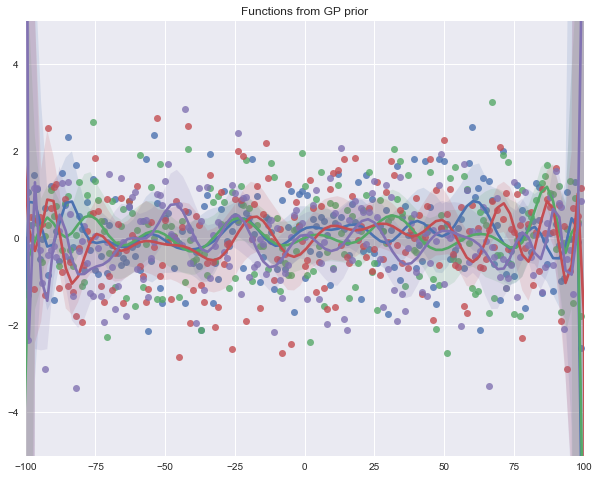

In [399]:

plt.figure(figsize=(10,8))
plt.title('Functions from GP prior')
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=32)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=25)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order = 27)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]), order = 31)
plt.xlim(-100,100)
plt.ylim(-5,5)

## Noise free predictive distribution

$f∗|X∗, X,f ∼ N
K(X∗, X)K(X, X)
−1
f,
K(X∗, X∗) − K(X∗, X)K(X, X)
−1K(X, X∗)
$

Squarred Exponential =

- $exp
−
1
2
|xp − xq|
2

.$

In [640]:
squarred_exp_cv = lambda x_train,x_test : np.exp(-.5*abs(x_train - x_test)**2)

In [641]:
training = range(-100,100)
test = range(-200,100)
cov_training_training  = np.array([[cov_normal(x_,x_) for x_ in range(-100,100)] for _ in range(-100,100)])
cov_training_test = np.array([[cov_normal(x_,x) for (x_,x) in zip(range(-100,100),range(-200,100))]
                              for _ in range(-100,100)])

# Noisy predictive distribution
- training points = (-100,100)
- test points = (-200,300,400) # only two

In [517]:
training_funcion  =  lambda x: x/4

In [827]:
train_x = np.linspace(-500,100,300) # x values
test_x = np.linspace(-10,99,20)
train_y = np.array(list(map(training_funcion,train_x))).reshape(-1,1) # columns vector
train_y_var = np.var(train_y)

In [828]:
list(test_x)

[-10.0,
 -4.2631578947368425,
 1.473684210526315,
 7.2105263157894726,
 12.94736842105263,
 18.684210526315788,
 24.421052631578945,
 30.157894736842103,
 35.89473684210526,
 41.631578947368418,
 47.368421052631575,
 53.105263157894733,
 58.84210526315789,
 64.578947368421041,
 70.315789473684205,
 76.05263157894737,
 81.78947368421052,
 87.526315789473671,
 93.263157894736835,
 99.0]

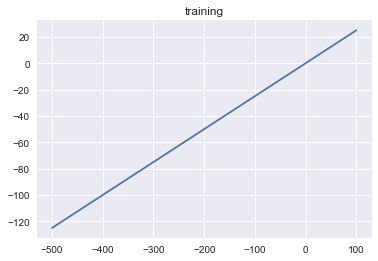

In [829]:
plt.plot(train_x,train_y)
plt.title('training');

In [830]:
train_y_var

1887.5418060200668

In [831]:

#squarred exponential covariance kernel
squarred_exponential_kernel = lambda x_,x: np.exp(-.5*(x_ - x)**2)


In [832]:
# find the covariance between the data points
cov_test_train_matrix = np.zeros((len(test_x),len(train_x)))
cov_test_test_matrix = np.zeros((len(test_x),len(test_x)))
cov_train_test_matrix = np.zeros((len(train_x),len(test_x)))
cov_train_train_matrix = np.zeros((len(train_x),len(train_x))) # assume noisy prediction
                                 

for idx_test, x_test in enumerate(test_x):
    for idx_train, x_train in enumerate(train_x):
        cov_test_train_matrix[idx_test,idx_train] = squarred_exponential_kernel(x_test,x_train)

for idx_test1, x_test1 in enumerate(test_x):
    for idx_test2, x_test2 in enumerate(test_x):
        cov_test_test_matrix[idx_test1,idx_test2]= squarred_exponential_kernel(x_test1,x_test2)
                                 
for idx_train, x_train in enumerate(train_x):
    for idx_test, x_test in enumerate(test_x):
        cov_train_test_matrix[idx_train,idx_test] = squarred_exponential_kernel(x_train,x_test)

for idx_train1, x_train1 in enumerate(train_x):
    for idx_train2, x_train2 in enumerate(train_x):
        cov_train_train_matrix[idx_train1,idx_train2] = squarred_exponential_kernel(x_train1,x_train2)
        
 

In [833]:
 # assume noisy predictions so teh covariance between the training points (train,train) has
# to add the variance of the y values
training_y_cov_matrix = np.zeros((len(cov_train_train_matrix),len(cov_train_train_matrix)), int)
np.fill_diagonal(training_y_cov_matrix, train_y_var)

In [834]:
cov_train_train_matrix = cov_train_train_matrix  + training_y_cov_matrix 

In [835]:
expected_mean_noisy_predictions = cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix) @train_y 

In [836]:
expected_mean_noisy_predictions  # test points,  predicted means

array([[-0.00167084],
       [-0.00071718],
       [ 0.00025115],
       [ 0.00120127],
       [ 0.00212311],
       [ 0.00304346],
       [ 0.00400115],
       [ 0.00500526],
       [ 0.00601691],
       [ 0.00697653],
       [ 0.00785747],
       [ 0.00869936],
       [ 0.00958654],
       [ 0.01058178],
       [ 0.01166724],
       [ 0.01274557],
       [ 0.01370913],
       [ 0.01452828],
       [ 0.015287  ],
       [ 0.01598296]])

In [837]:
test_x

array([-10.        ,  -4.26315789,   1.47368421,   7.21052632,
        12.94736842,  18.68421053,  24.42105263,  30.15789474,
        35.89473684,  41.63157895,  47.36842105,  53.10526316,
        58.84210526,  64.57894737,  70.31578947,  76.05263158,
        81.78947368,  87.52631579,  93.26315789,  99.        ])

In [838]:
expected_cov_noisy_predictions = cov_test_test_matrix - cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix)\
                    @ cov_train_test_matrix

In [839]:
expected_cov_noisy_predictions 

array([[  9.99499413e-001,  -3.60707238e-008,   7.86504468e-017,
         -5.15134731e-028,  -2.91415662e-036,   1.87762374e-046,
          1.02682962e-055,  -1.70319300e-065,  -4.11947444e-075,
          9.12557027e-085,   1.49613620e-094,  -3.91486962e-104,
         -3.27262773e-114,   1.82511162e-123,   2.50369655e-135,
         -8.98954200e-143,   2.74379175e-153,   3.69846602e-162,
         -2.20024988e-172,  -1.22776682e-181],
       [ -3.60707238e-008,   9.99454295e-001,  -3.11993651e-008,
          7.69513909e-017,  -1.38551157e-027,  -2.73281573e-036,
          2.77597656e-046,   1.05526401e-055,  -1.93786500e-065,
         -4.29064505e-075,   9.02252488e-085,   1.31238418e-094,
         -4.01961701e-104,  -2.03985061e-114,   2.02809226e-123,
         -1.50649332e-134,  -9.40413495e-143,   2.79690327e-153,
          3.46266838e-162,  -2.86829236e-172],
       [  7.86504468e-017,  -3.11993651e-008,   9.99466599e-001,
         -4.20315855e-008,   6.85806383e-017,  -2.87759630e-0

In [840]:
expected_cov_noisy_predictions.shape # NXN for the test points

(20, 20)

### Now, define a normal distribution given the parameters above

In [841]:
predictive_normal_noisy = sp.stats.multivariate_normal(expected_mean_noisy_predictions.ravel(),
                                                       expected_cov_noisy_predictions  )

In [842]:
predictive_normal_noisy.rvs()

array([ 0.11631433,  0.63064788, -0.14584552,  0.05949357, -1.9149441 ,
        0.48986877, -0.16532072,  0.46508993,  0.11344726, -0.6033401 ,
        1.0326625 , -1.96165292, -1.24253234, -0.19303591,  0.29424613,
       -0.28887835, -1.31724066,  1.15679366,  0.76111333, -1.07773477])

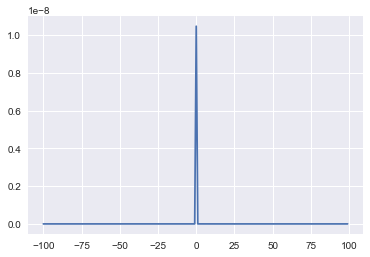

In [843]:
plt.plot(range(-100,100),[predictive_normal_noisy.pdf(i) for i in range(-100,100)])

In [844]:
predictive_normal_noisy.rvs(range_)

array([ 1.85273482, -1.29383106, -1.10035843,  0.96259757, -1.90368937,
       -1.7980305 , -2.67960172,  0.16163663,  1.48228845,  1.12602373,
        0.55455149,  0.60640082, -1.17230058,  0.11380901, -0.58935768,
       -1.15488053,  1.35193244,  0.51629356,  0.70305001, -1.59059142])

In [845]:
test_x

array([-10.        ,  -4.26315789,   1.47368421,   7.21052632,
        12.94736842,  18.68421053,  24.42105263,  30.15789474,
        35.89473684,  41.63157895,  47.36842105,  53.10526316,
        58.84210526,  64.57894737,  70.31578947,  76.05263158,
        81.78947368,  87.52631579,  93.26315789,  99.        ])

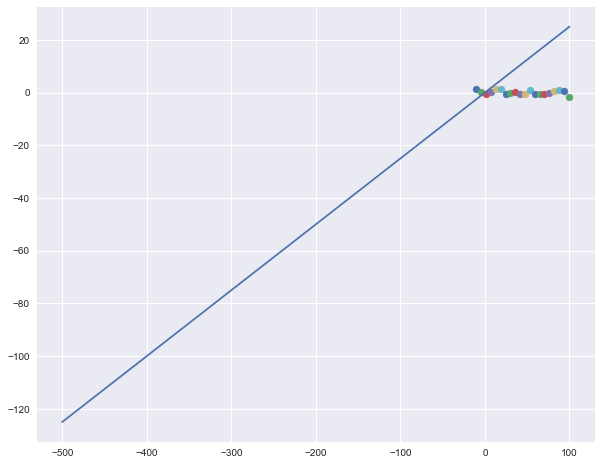

In [846]:
plt.figure(figsize=(10,8))
range_ = 1
predicted_points = predictive_normal_noisy.rvs(range_).T
#plt.scatter(test_x[0] ,predicted_points[0])

[plt.scatter(test_x[i],predicted_points[i]) for i in range(len(test_x))]
#plt.scatter(test_x[2],predicted_points[2])
#3plt.scatter(test_x[3],predicted_points[3])
plt.plot(train_x,train_y)
#plt.scatter(test_x[0],training_funcion(test_x[0]),label='X');#

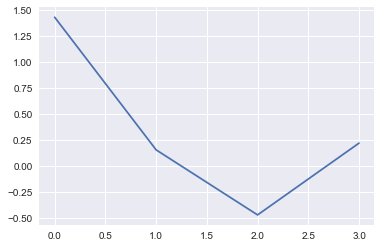

In [847]:
plt.plot([np.mean(predicted_points[0]), np.mean(predicted_points[1]), np.mean(predicted_points[2]),
         np.mean(predicted_points[3])])

In [ ]:
np.random.multivariate_normal()

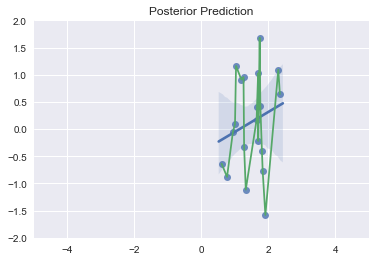

In [549]:
# random draws from the distrbution's posterior predictive
predicted_points = predictive_normal_noisy.rvs(20).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points
sns.regplot(*predicted_points,order=1)

#sns.regplot(*predicted_points,order=2)
plt.plot(*np.array(sorted(predicted_points.T, key=lambda x: x[0])).T) # plot them in order of smallest to largest
plt.xlim(-5,5)
plt.ylim(-2,2);
plt.title('Posterior Prediction')

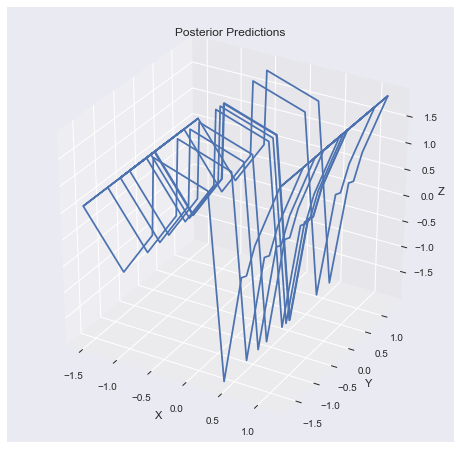

In [469]:


predicted_points = predictive_normal_noisy.rvs(10).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

#t = np.linspace(-3, 2, 31)
#s = np.linspace(-3, 2, 31)
x = predicted_points[0]
y = predicted_points[1]
z = predicted_points[2]

X, Y = np.meshgrid(x,y)
Z  = np.meshgrid(z,y)

ax.plot_wireframe(X,Y,Z[0],ccount=1, rcount=10)
#ax.plot_wireframe(X,Y,Z[1],ccount=1)
#ax.plot_surface(x,y,z, cmap=cm.jet, rstride=1, cstride=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Posterior Predictions')

plt.show()

In [1708]:


x, y = np.mgrid[-5.0:5.0:50j, -5.0:5.0:50j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])
print(xy)
mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z =predictive_normal_noisy .pdf(xy)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)





fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(x,y,z)
#ax.plot_wireframe(x,y,z)
plt.title('PDF of multivariate gaussian process')
plt.show()

[[-5.         -5.        ]
 [-5.         -4.79591837]
 [-5.         -4.59183673]
 ..., 
 [ 5.          4.59183673]
 [ 5.          4.79591837]
 [ 5.          5.        ]]


ValueError: operands could not be broadcast together with shapes (2500,2) (20,) 

# New Attempt from Readings. Bayesian Gaussian Process Regression
- Gaussian Process for Regression: A Quick Introduction
    - M. Ebden
- http://haikufactory.com/files/bayopt.pdf

###  Assmptions
- Prior is a Gaussian Process with mean = 0

In [1155]:
def squarred_kernel(a, b, param=2.0, train=False, train_noise = 5e-5):
    """Calculated the squarred exponential kernel. 
    Adds a noise term for the covariance of the training data
    Adjusting the param changes the difference where points will have a positive covariance
    Returns a covaraince Matrix"""
    if train == False:
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return np.exp(-.5 * (1/param) * sqdist)

    else:
        noisy_observations = train_noise*np.eye(len(a))
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) 
        return np.exp(-.5 * (1/param) * sqdist) + noisy_observations 

In [1063]:
def matern_kernel(a,b,C_smoothness=3/2,train=False, train_noise = 5e-2):
    """The class of Matern kernels is a generalization of the RBF and the
    absolute exponential kernel parameterized by an additional parameter
    nu. The smaller nu, the less smooth the approximated function is.
    For nu=inf, the kernel becomes equivalent to the RBF kernel and for nu=0.5
    to the absolute exponential kernel. Important intermediate values are
    nu=1.5 (once differentiable functions) and nu=2.5 (twice differentiable
    functions).
    
    c_smoother = inf = RBF
    
    The train keyword is used to add noisy observations to the matrix"""
    matrix_norm = np.array([np.linalg.norm(a[i] - b,axis=(1)) for i in range(len(a))])
    if C_smoothness == 1/2:
        if train == True:
            max(np.var(a),np.var(b)) * np.exp(-matrix_norm) + np.eye(len(matrix_norm))*train_noise
        else:
            return max(np.var(a),np.var(b)) * np.exp(-matrix_norm)
    elif C_smoothness == 3/2:
        if train == True:
            return max(np.var(a),np.var(b))* (1 +np.sqrt(3)*matrix_norm)*np.exp(-np.sqrt(3)*matrix_norm) + np.eye(len(matrix_norm))*train_noise
        else:
            return max(np.var(a),np.var(b))* (1 +np.sqrt(3)*matrix_norm)*np.exp(-np.sqrt(3)*matrix_norm)
 
   

In [510]:
from math import pi

In [1252]:
test_x = np.array(np.linspace(-40,40,100)).reshape(-1,1)
train_x = np.array(np.linspace(-100,100,5)).reshape(-1,1)
train_y_func = lambda x: cos(1000*x)+(abs(x*100_000))/(x**4+1000)
#train_y_func = lambda a,b : (a*b)/(a**2) - b
train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
y_var = np.var(train_y_numbers)
#max_covariance = np.sqrt(y_var) ## not sure a good number to choose for the noise of measuring your observations
max_covariance = 5


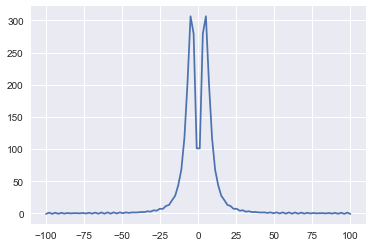

In [980]:
plt.plot(np.linspace(-100,100,100),[train_y_func(i) for i in np.linspace(-100,100,100)])

In [981]:
zero_vecs = vecs [vals<0]
zero_vals = vals[[vals<0]]

In [982]:
new_matrix = matern_kernel(test_x,test_x)
for i in range(len(zero_vecs)):
    print(i)
    

    new_matrix = (np.array(vecs [vals<0][i,:]).reshape(-1,1) @ (np.array( vecs [vals<0][i,:]).reshape(-1,1).T))   \
    *(sys.float_info.epsilon-vals[vals<0][i])\
                  +new_matrix
    vals, vecs = np.linalg.eig(new_matrix)


In [1057]:
from numpy import linalg as la
#https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194#43244194
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [1068]:
def test_gaussian_process(test_x, train_x, train_y_numbers, y_var, kernel, return_cov = False,
                          return_sample = False, covariance_noise = 5e-5, n_posteriors = 5):
    """Test one new point in the Gaussian process or an array of points
    Returns the mean, var from normal distribution from the sampled point.
    Return cov = True will return the full covariance matrix.
    
    If return_sample= True 
    returns samples from the informed posterior and the uninformed prior distribution
    
    Covariance noise is used to help enforce positive definite matrices
    
    N_posteriors indicates the number of posterior functions to create"""
    
    y_var = np.var(train_y_numbers)
    
    # define the covaraince functions
    covariance_train_train = kernel(train_x,train_x,train=True)
    
    covariance_test_train  = kernel(test_x,train_x)
    covariance_test_test  = kernel(test_x,test_x)
    

    # Use cholskey decomposition to increase speed for calculating mean
    try :# First try, not inside function
        L_test_test = np.linalg.cholesky(covariance_test_test + covariance_noise*np.eye(len(covariance_test_test)))
        L_train_train = np.linalg.cholesky(covariance_train_train + covariance_noise*np.eye(len(covariance_train_train)))
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        

    # Full matrix calculation of mean and covariance, much slower than cholesky decomposition
    except Exception as e:
        print(e)#LinAlgError: # In case the covaraince matrix is not positive definite 
        # remove the negative eigenvalues, replace with the covariance noise , recompute the covariance matrix
        
#         vals_train_train, vecs_train_train = np.linalg.eig(covariance_train_train + covariance_noise*np.eye(len(train_x)))
#         vals_test_test, vecs_test_test = np.linalg.eig(covariance_test_test + covariance_noise*np.eye(len(test_x)))
#         # replace negative eigenvalues
#         vals_train_train[vals_train_train<0] = 5e-15
#         vals_test_test[vals_test_test<0] = 5e-15
#         # recompute matrix
#         covariance_train_train = vecs_train_train @ np.eye(len(vecs_train_train))*vals_train_train @vecs_train_train.T
#         covariance_test_test = vecs_test_test @ np.eye(len(vecs_test_test))*\
#             vals_test_test @vecs_test_test.T
# #         print(covariance_test_test.shape,'cov test test shape')
# #         print()
#         print(np.linalg.eig(covariance_test_test), ' cov test test after removing negative eigen vals')
        decompose_train_train = nearestPD(covariance_train_train + covariance_noise*np.eye(len(train_x)))
        decompose_test_test = nearestPD(covariance_test_test + covariance_noise*np.eye(len(test_x)))
        
        # cholskey decomposition within the try except block
        L_train_train = np.linalg.cholesky(decompose_train_train  )
        L_test_test = np.linalg.cholesky(decompose_test_test  )
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        
        
#         ##### FULL INVERSION IN CASE REMOVING NEGATIVE EIGENVAL DOESN"T WORK ####
#         mus = covariance_test_train  @ np.linalg.pinv(covariance_train_train) @ train_y_numbers
#         s2 = covariance_test_test - covariance_test_train @ np.linalg.pinv(covariance_train_train ) \
#                      @ covariance_test_train.T
        
    

    def sample_from_posterior(n_priors=3, n_post=5):
        """Draw samples from the prior distribution of the GP.
        len(test_x) is the number of samplese to draw.
        Resource: http://katbailey.github.io/post/gaussian-processes-for-dummies/.
        
        N-Posteriors / N-Priors tells the number of functions to samples from the dsitribution"""

        
        # Draw samples from the posterior at our test points.
        covariance_test_test  = kernel(test_x,test_x)
        try: # try inside sample from posterior function
            L = np.linalg.cholesky(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
        except Exception as e:
            near_decompose = nearestPD(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
            # decompose the nearest matrix
#             vals_test_test, vecs_test_test = np.linalg.eig(near_decompose)
            
#             # replace with small number
#             vals_test_test[vals_test_test<0] = 5e-2
# #             # recompute
           
#             covariance_test_test = vecs_test_test @ (np.eye(len(vecs_test_test))*\
#                 vals_test_test) @vecs_test_test.T
            
# #             #d_test_test = covariance_test_test + covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk)
# #             ##### calculate L 
# # #             decompose = covariance_test_test +  covariance_noise*np.eye(len(test_x)) - np.dot(Lk.T, Lk)
# #             decompose = decompose + 5e-1*np.eye(len(decompose))
#             print(np.linalg.eig(covariance_test_test ),'ear decompose decomposition')
            L = np.linalg.cholesky(near_decompose.astype(float) ) # within posterior

            
            
        f_post = mus.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(test_x),n_posteriors)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior_uninformed = np.dot(L_test_test, np.random.normal(size=(len(test_x),n_priors)))
        # For the posterior, the columns are the vector for that function
        return (f_prior_uninformed, f_post)


    if return_cov == True:
        return y_pred_mean.ravel(), var_y_pred_diag.ravel(), var_y_pred
        
    if return_sample == True:
        f_prior, f_post = sample_from_posterior(n_post = n_posteriors)
        return mus.ravel(), s2.ravel(), f_prior, f_post
    else:
        return mus.ravel(), s2.ravel()
    
   

In [1069]:
m,var, prior, post = test_gaussian_process(np.array([[-10]]), train_x, train_y_numbers, 
                                                   y_var,squarred_kernel, return_sample = True)

In [1070]:

def sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process,kernel, range_to_sample=np.linspace(-35,35,25)):
    """Plot potential posterior functions after sampling from the true function.
    Notice how the varaince decreases around the sampled points"""
    train_x = np.array(np.linspace(-40,40,1)).reshape(-1,1)
    train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
    # shuffle the range
    shuffle(range_to_sample)
    # go through the points in the range
    for sampled_point in range_to_sample:
        print(f"Point Sampled x = {train_x.ravel()[-1]}")
        m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,kernel, return_sample = True)

        plt.figure(figsize=(14,10))

        plt.gca().fill_between(test_x.flat, m-2*np.sqrt(var), m+2*np.sqrt(var), color="#dddddd",label='95% confidence')
        plt.scatter(train_x.ravel(), train_y_numbers,marker='*',label='Samples', linewidth=5, color='red')

        plt.plot(np.linspace(-40,40,400),[train_y_func(i) for i in np.linspace(-40,40,400)], label='real function',
                linestyle="--")
        plt.plot(test_x,post,color='black',label='Draws from the posterior')
        #plt.scatter(train_x,train_y_numbers)
        #plt.scatter(test_x,m,label='MU',color='red', linewidth=10, marker='*');
        plt.legend()
        plt.title('Posteriors, and Actual Function')
        plt.show();

        # Update training data with the sampled point
        train_x = train_x.ravel()
        train_x = np.append(train_x,sampled_point)
        train_x = train_x.reshape(-1,1)
        train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)

        # sleep for three seconds
        time.sleep(1)

Point Sampled x = -40.0


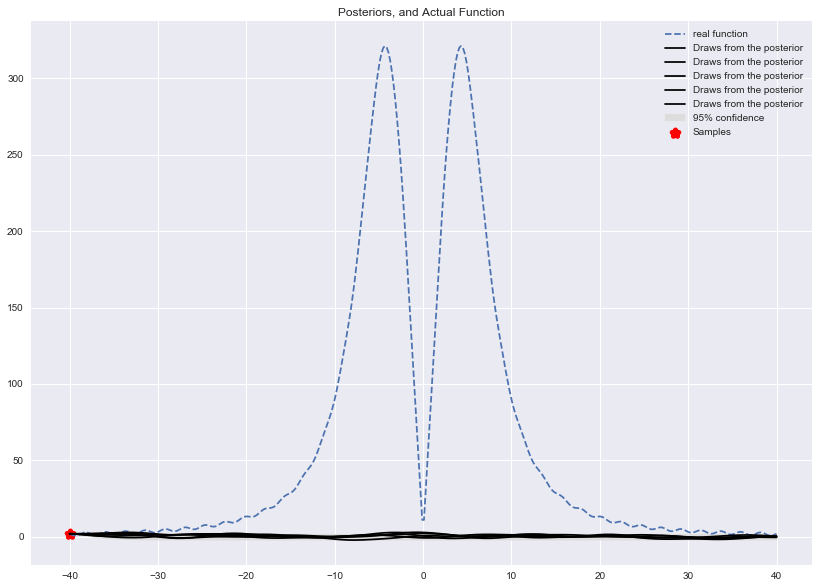

Point Sampled x = 8.75


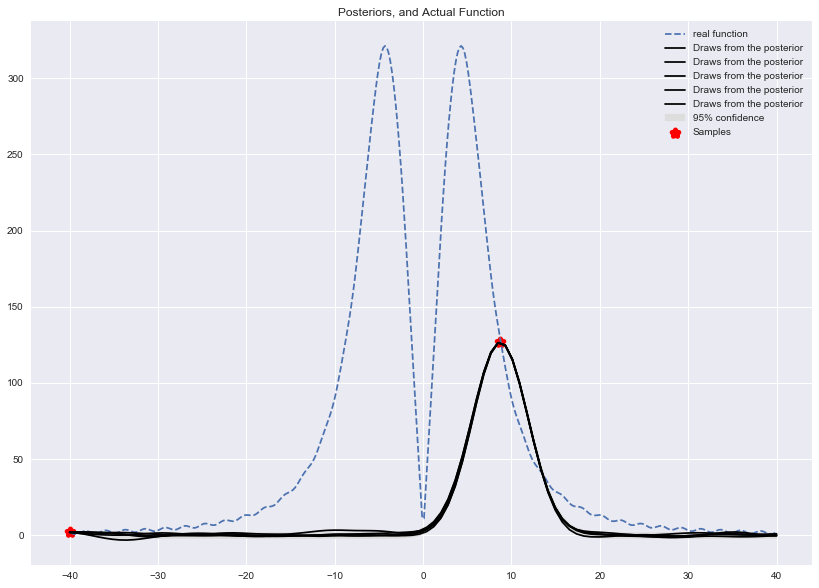

Point Sampled x = 5.833333333333329


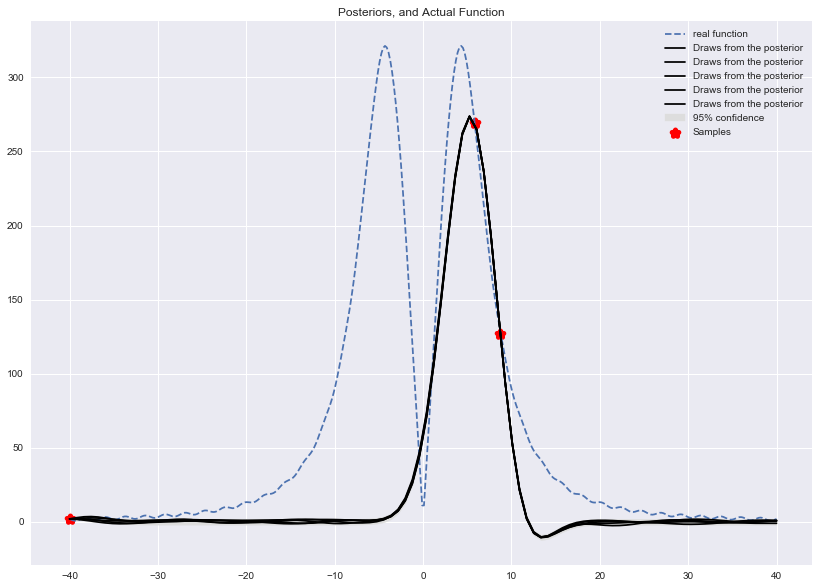

Point Sampled x = 20.416666666666664


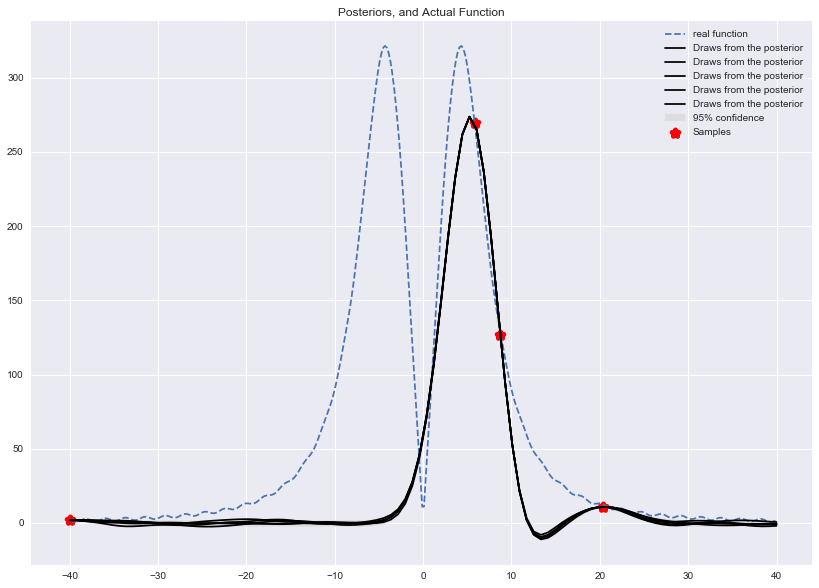

Point Sampled x = 35.0


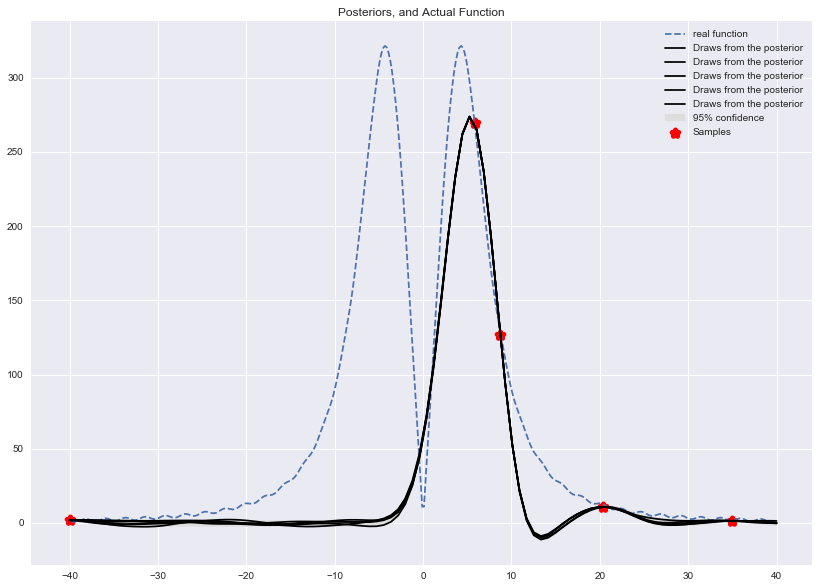

Point Sampled x = -14.583333333333336


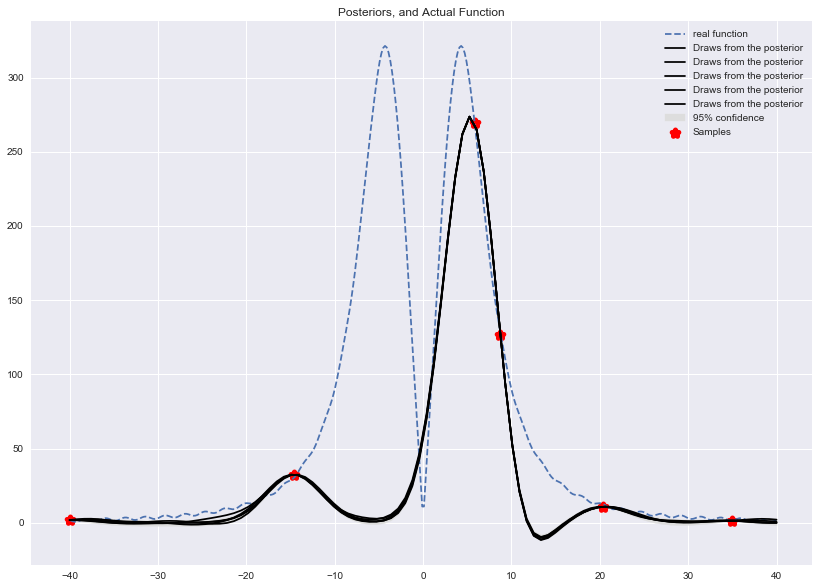

KeyboardInterrupt: 

In [1071]:
sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process, squarred_kernel)

### Best estimate for Y* is given by the mean of the distribution


### Implement Expected Improvement


In [1072]:
def expected_improvement(mean_x, sigma_squarred_x, y_val_for_best_hyperparameters, normal_dist=None, point_est = False):
    """Finds the expected improvement of a point give the current best point.
    If point_est = False, then computes the expected value on a vector from the posterior distribution.
    """
    from scipy.stats import norm
    
    with np.errstate(divide='ignore'): # in case sigma equals zero
        # Expected val for one point
        if point_est ==True:
            sigma_x = np.sqrt(sigma_squarred_x) # get the standard deviation from the variance

            Z = (mean_x - y_val_for_best_hyperparameters) / sigma_x

            if round(sigma_x,8) == 0:
                return 0
            else:
                return (mean_x - y_val_for_best_hyperparameters)*normal_dist.cdf(Z) + sigma_x*normal_dist.pdf(Z)

        else:
            # Sample from the posterior functions
            for _ in range(len(mean_x)):
                list_of_improvements = []
                m_s = []
                for m,z,s in zip(mean_x, ((mean_x -y_val_for_best_hyperparameters)\
                                     / np.std(sigma_squarred_x)),np.sqrt(sigma_squarred_x) ):
                    
                    list_of_improvements.append(((m-y_val_for_best_hyperparameters)*norm(m,s).cdf(z)\
                                                 +s*norm(m,s).pdf(z)))
                    m_s.append(m)
                    #print(m-y_val_for_best_hyperparameters,'top of Z')
                    
                    #print(norm(m,s).pdf(z),'norm(m,s).pdf(z)')
                    #print(z,'z')
                    #print(norm(m,s).cdf(z),'norm(m,s).cdf(z')
                    #print(m,'m')
                    #print(y_val_for_best_hyperparameters,'y_val_for_best_hyperparameters')
                    #print(s,'standard deviation BOTTOM OF Z')
                    #print()
                #print("min max Mu",min(m_s),max(m_s))
                return list_of_improvements

In [1073]:
def thompson_sampling():
    """Thompson sampling to find the next point to pick"""

In [1074]:
m,var, prior, post =  test_gaussian_process(np.array([[-400]]), train_x, train_y_numbers, 
                                                   y_var,squarred_kernel, return_sample = True)

In [1075]:
m

array([ 0.])

In [1435]:
def sample_from_function( y_function, 
                        train_x, train_y_numbers, kernel, y_var, testing_domain = range(-100,100,10), n = 20):
    """Sample N times from the unknown function and for each time find the 
    point that will have the highest expected improvement (find the maxima of the function).
    
    Returns a generator of x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, testing_domain, mus
          for improvements. Mus and Vars are the mean and var for each sampled point in the gaussian process. 
    
    Starts off the search for expected improvement with a coarse search and then hones in on 
    the domain the the highest expected improvement."""
    start_point = np.random.choice(testing_domain)#np.array(np.random.choice(testing_domain)).reshape(-1,1)
    best_x = start_point
    best_y = y_function(start_point) # initial best y value based on start point
    start_y = y_function(start_point) 
    # for plotting the points sampled
    x_sampled_points = []
    y_sampled_points = []
    sampled_variance =[] 
    

    for i in range(n):
        if i == 0:
            
            s_p = np.array([testing_domain]).reshape(-1,1)
            
            
            # find the next x-point to sample
            mus, vars_,_,post = test_gaussian_process(s_p, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)
            
           
            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post ,best_y)

            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = s_p[max_improv_x_idx]
  
            max_improv_y = y_function(max_improv_x  ) 
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                best_x = start_point
            

            sampled_variance.append(sigmas_post[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, s_p, mus
            

        else:
            # reformat testing domain to include more possible points
            testing_domain = np.linspace(testing_domain[0],testing_domain[-1],
                                        num=1_000).reshape(-1,1)
            
            
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)
     
            #print(min(mus),'min mu',max(mus),'max mus')
            #print(mus, ' all mus ')
            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post, best_y)
            
            # find the best x value
            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
  
            max_improv_y = y_function(max_improv_x ) 
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                pass
            print(f"Bayesian Optimization just sampled point = {max_improv_x}")
            print(f"Best x (Bayesian OPtimization) = {best_x}, Best y = {best_y}")

            sampled_variance.append(sigmas_post[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            #print(max_improv_x,'improv x - bayesian optimization')
            
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            
            yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, testing_domain, mus
         


    

In [1328]:
samples = 20

In [1329]:
y_var = np.array(y_var).reshape(-1,1)

In [1330]:
#x, y, variance_of_estimate, best_x,best_y = 
gen = sample_from_function(train_y_func,train_x, train_y_numbers,matern_kernel, y_var, n=samples )

Point on x-axis just sampled =[-90]


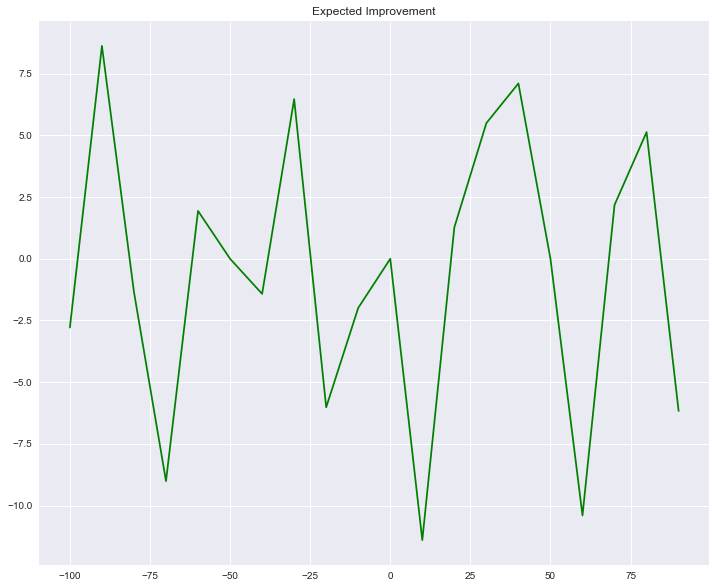

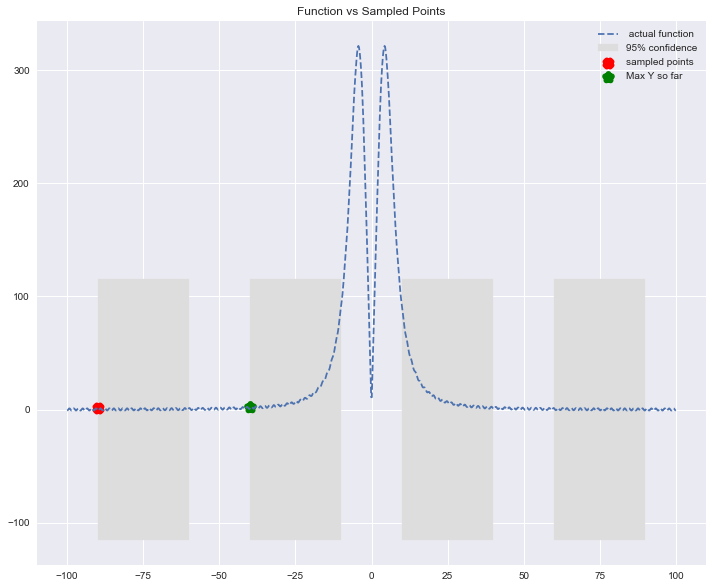

-40 best_x
[ 90.] improv x
Point on x-axis just sampled =[ 90.]


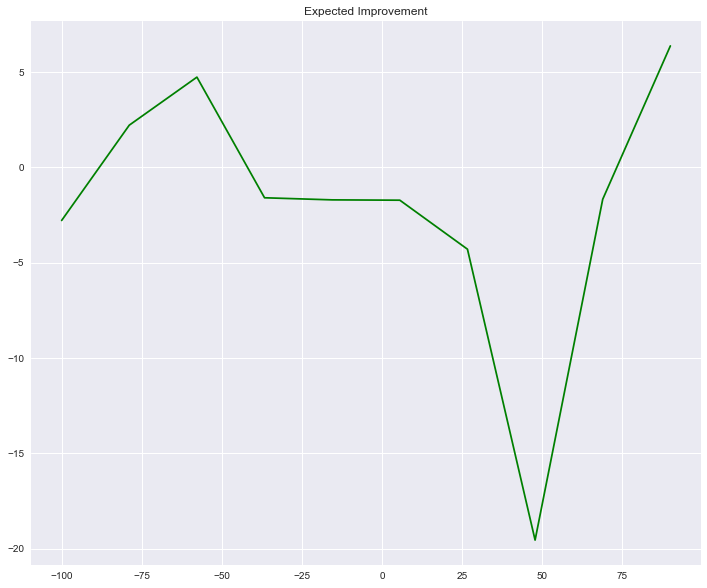

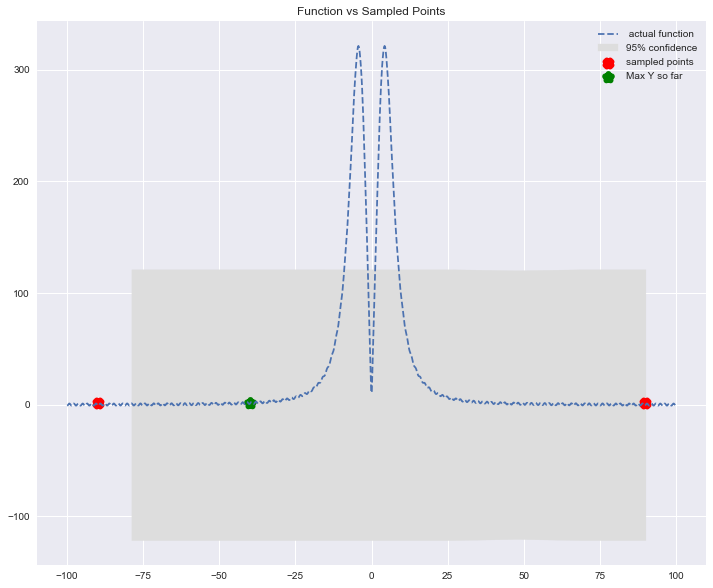

[-10.] best_x
[-10.] improv x
Point on x-axis just sampled =[-10.]


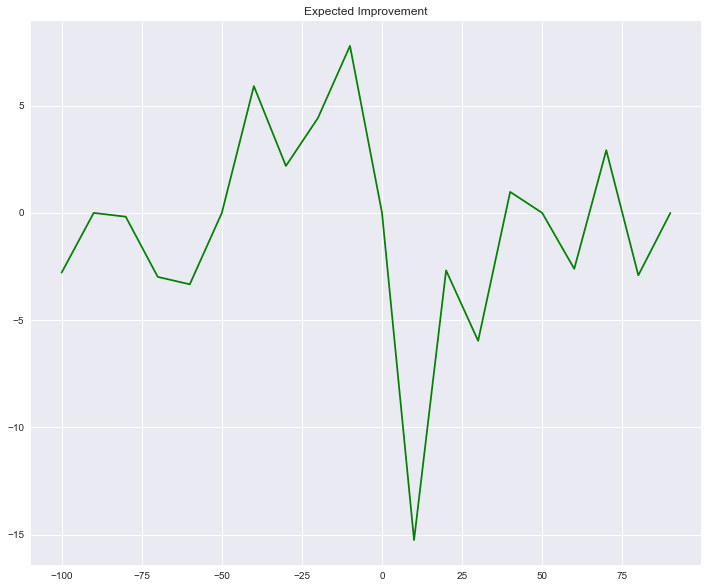

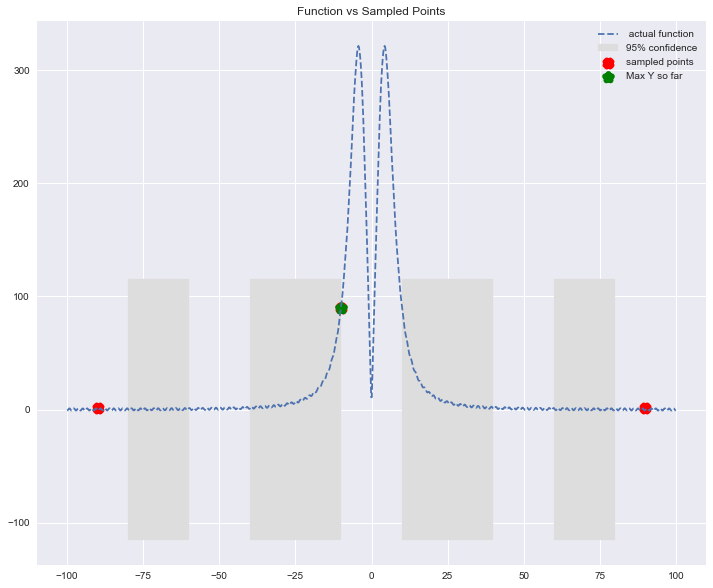

[-10.] best_x
[ 90.] improv x
Point on x-axis just sampled =[ 90.]


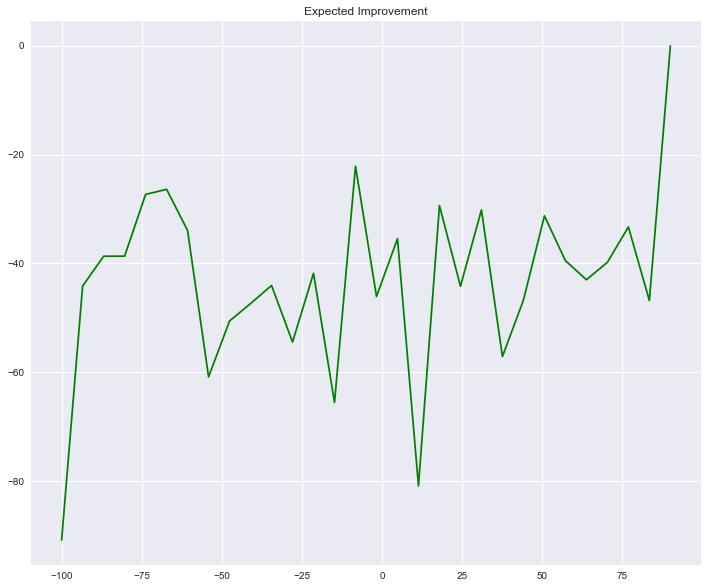

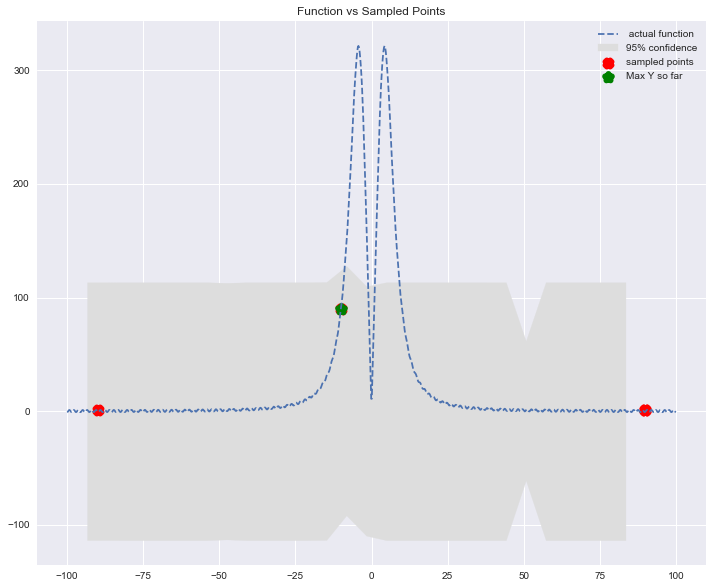

[-10.] best_x
[ 90.] improv x
Point on x-axis just sampled =[ 90.]


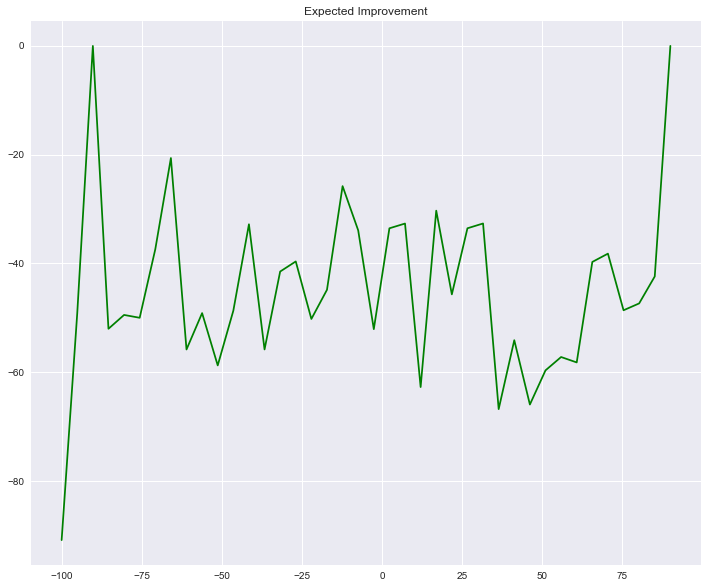

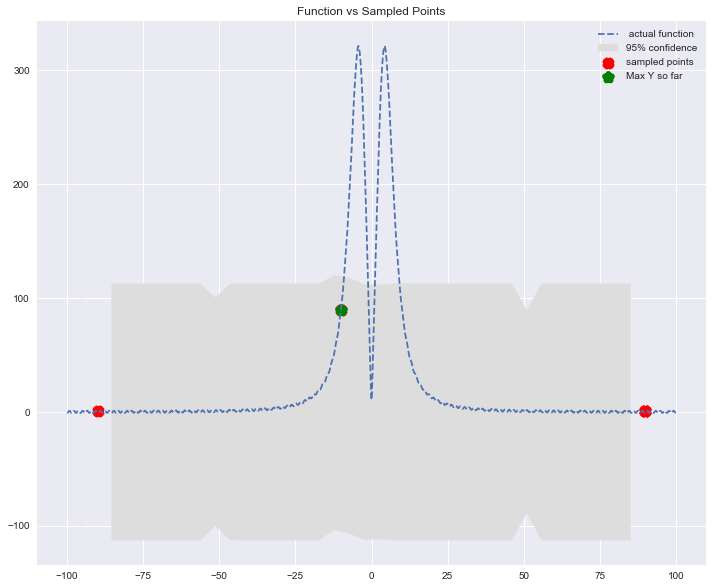

[-10.] best_x
[ 90.] improv x
Point on x-axis just sampled =[ 90.]


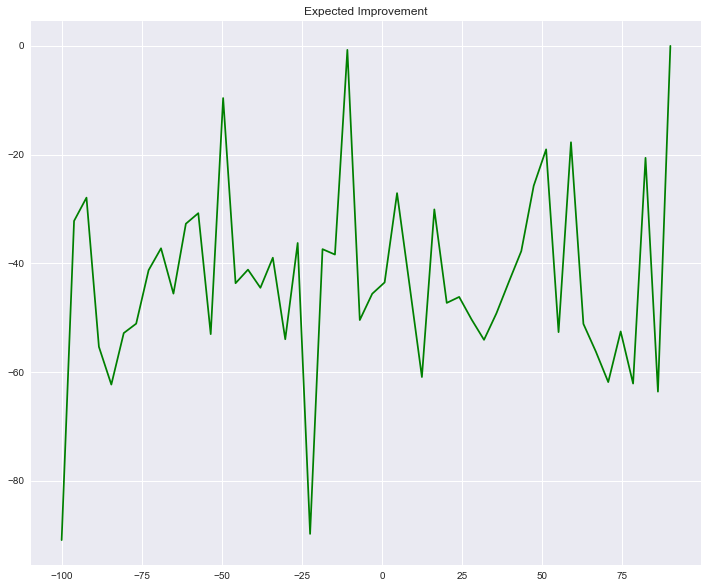

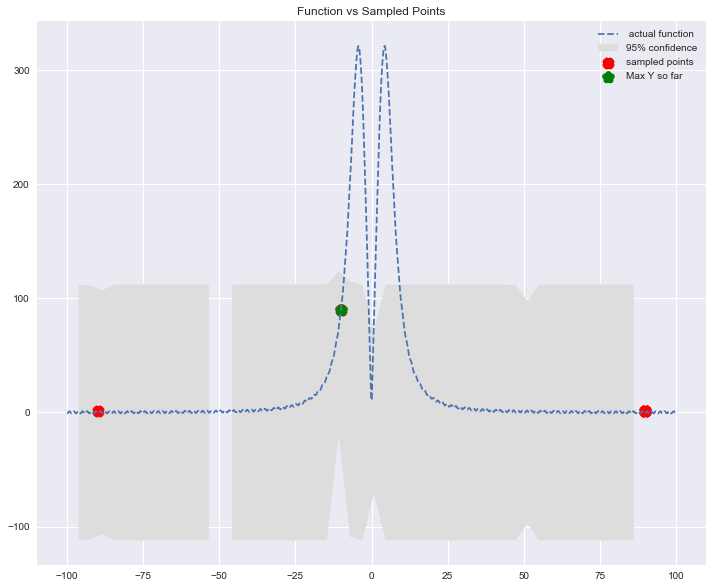

[-9.83050847] best_x
[-9.83050847] improv x
Point on x-axis just sampled =[-9.83050847]


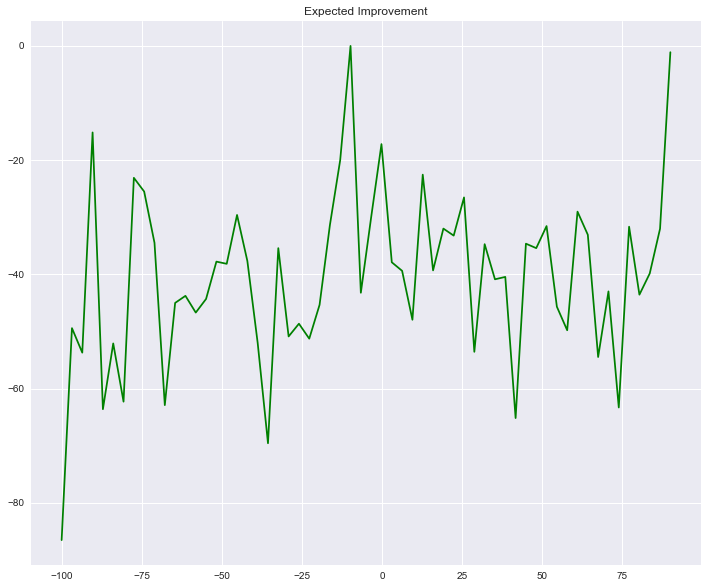

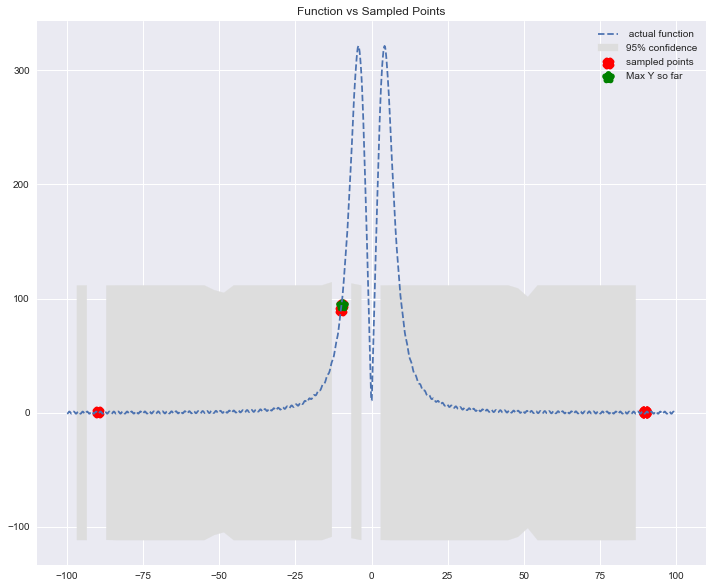

[-9.13043478] best_x
[-9.13043478] improv x
Point on x-axis just sampled =[-9.13043478]


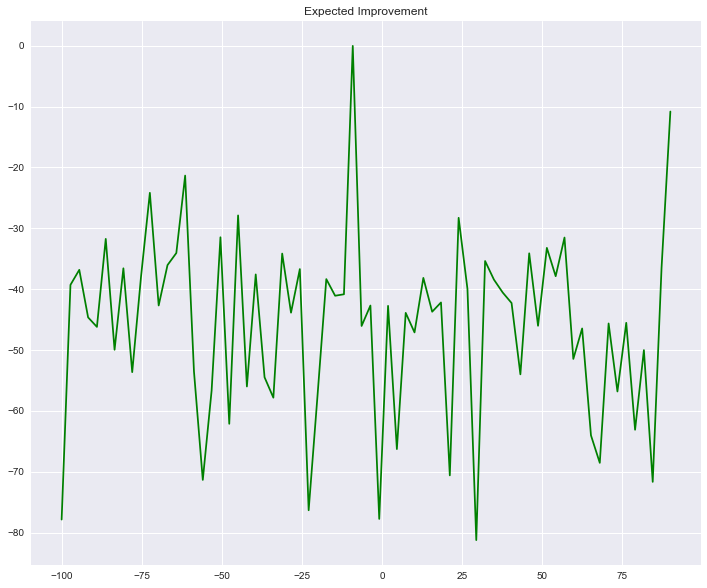

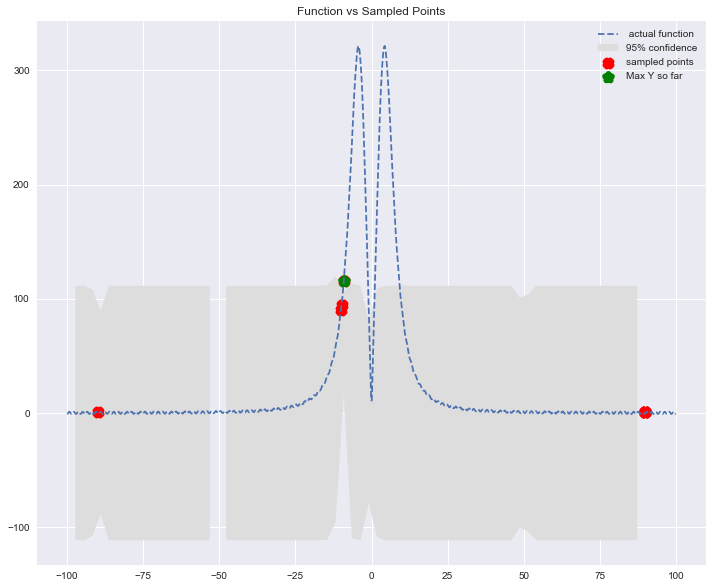

[-8.60759494] best_x
[-8.60759494] improv x
Point on x-axis just sampled =[-8.60759494]


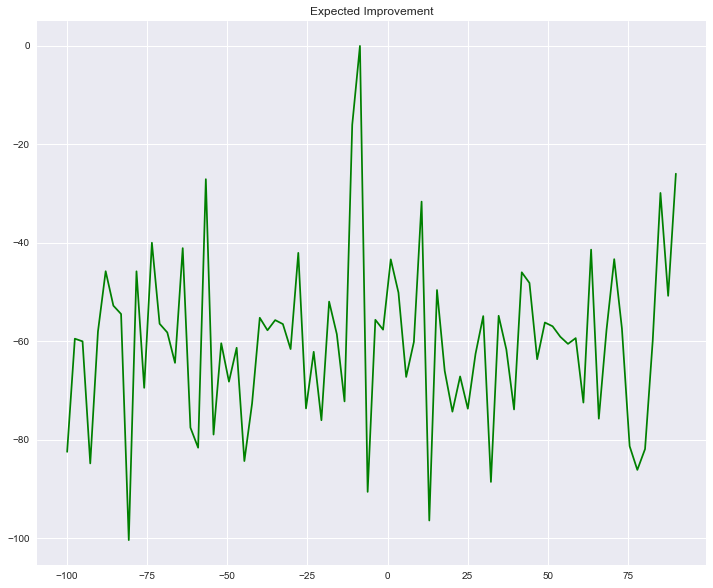

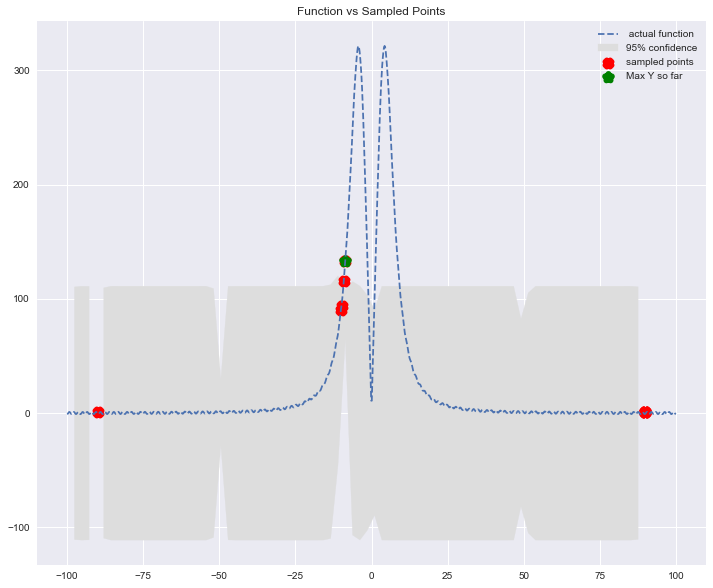

[-8.60759494] best_x
[-10.33707865] improv x
Point on x-axis just sampled =[-10.33707865]


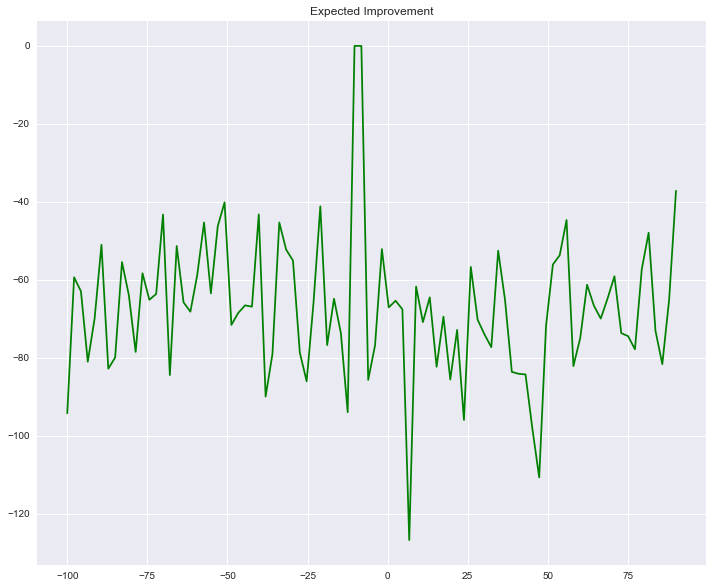

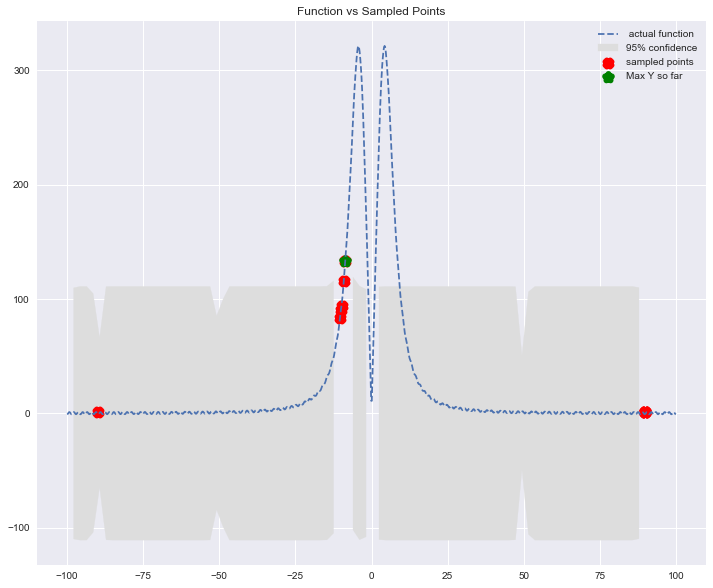

[-8.60759494] best_x
[-9.7979798] improv x
Point on x-axis just sampled =[-9.7979798]


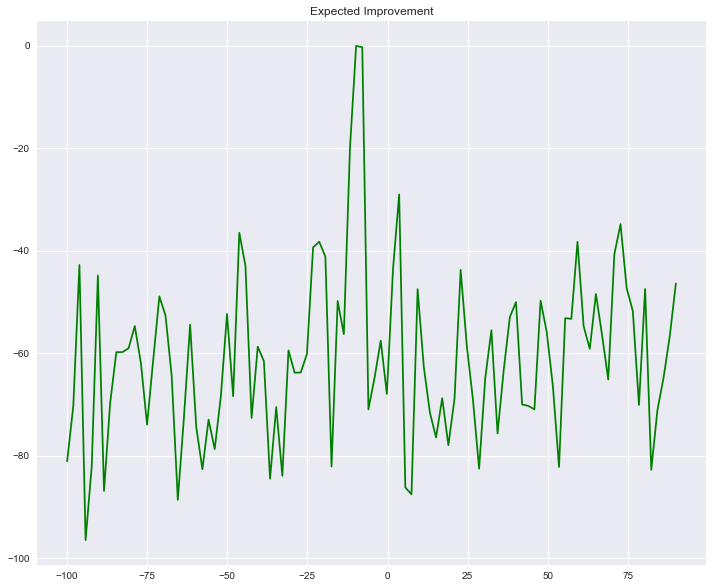

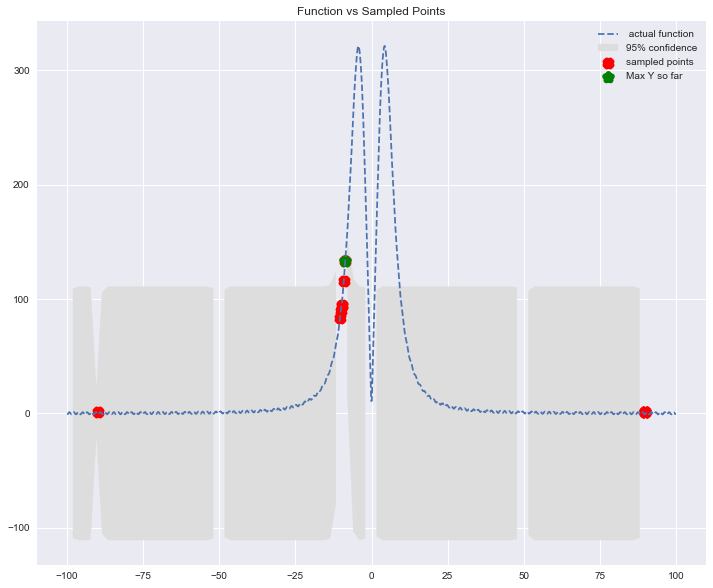

[-8.60759494] best_x
[-9.35779817] improv x
Point on x-axis just sampled =[-9.35779817]


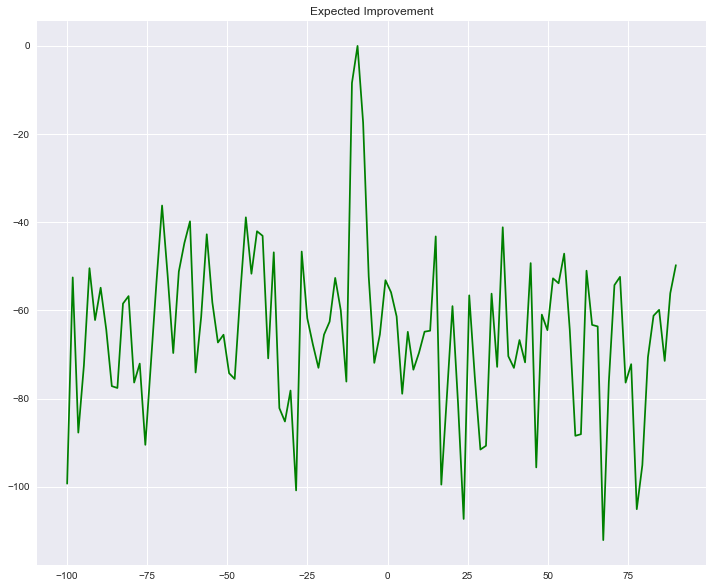

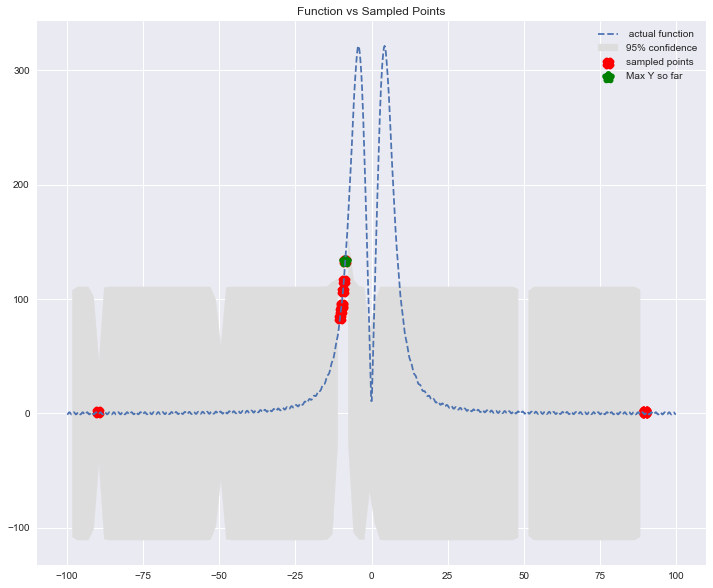

[-8.60759494] best_x
[-10.58823529] improv x
Point on x-axis just sampled =[-10.58823529]


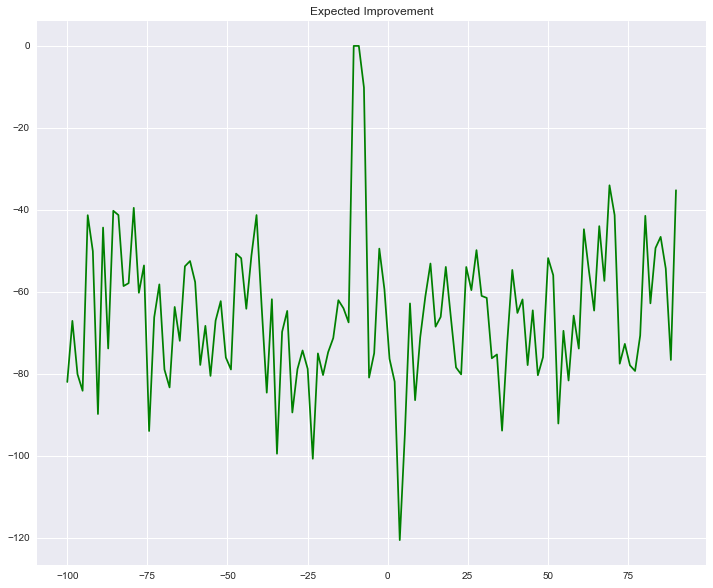

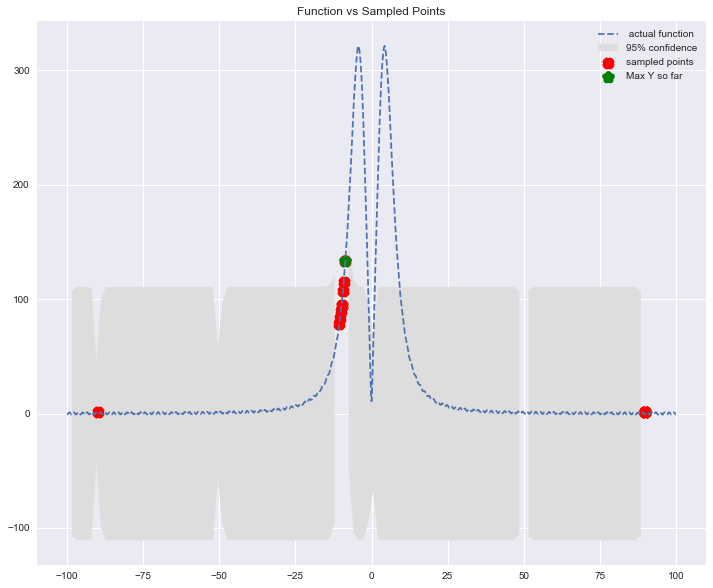

[-8.60759494] best_x
[-8.68217054] improv x
Point on x-axis just sampled =[-8.68217054]


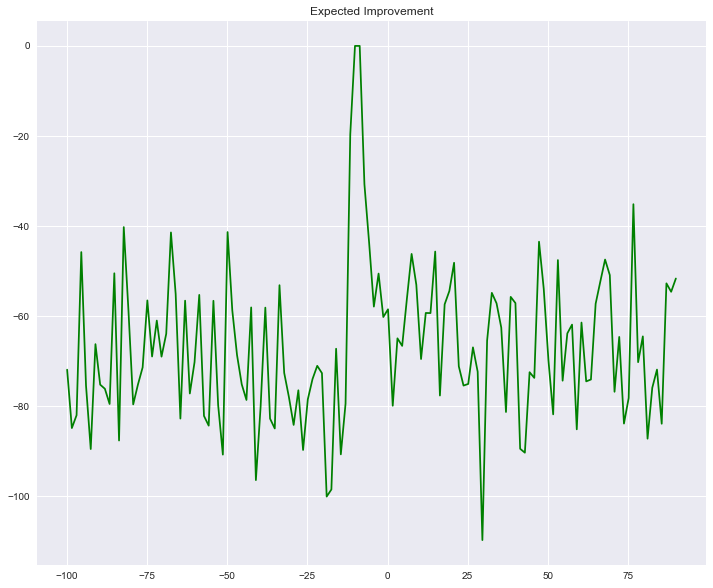

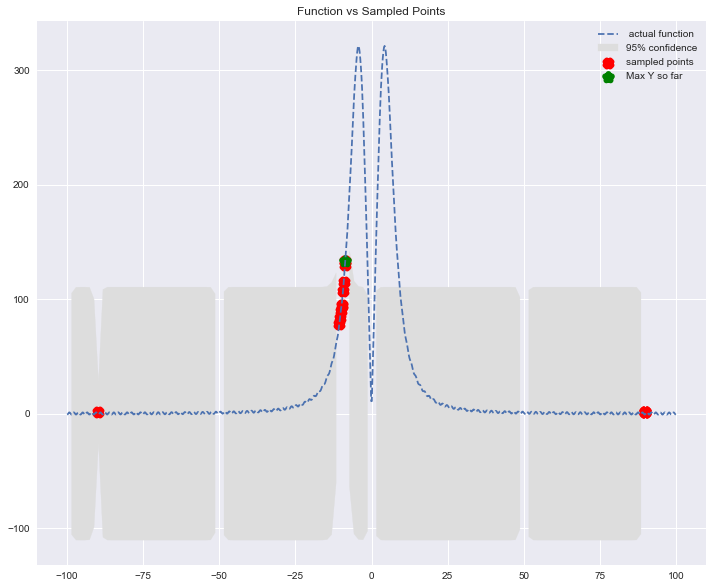

[-8.41726619] best_x
[-8.41726619] improv x
Point on x-axis just sampled =[-8.41726619]


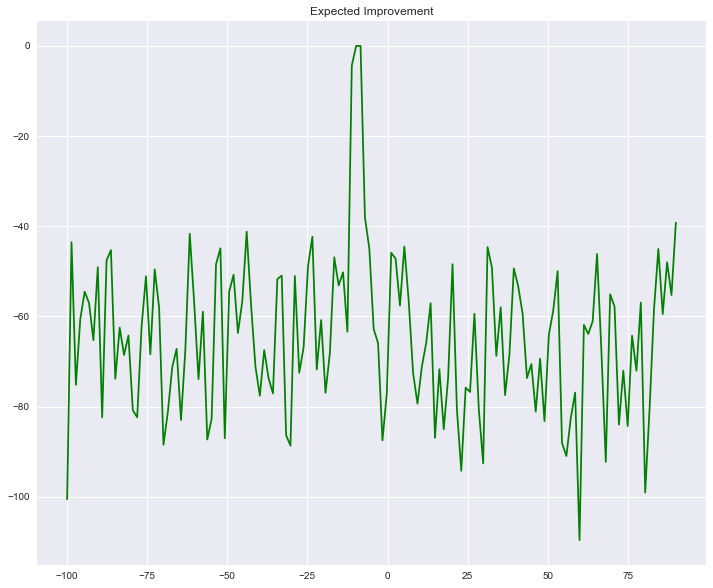

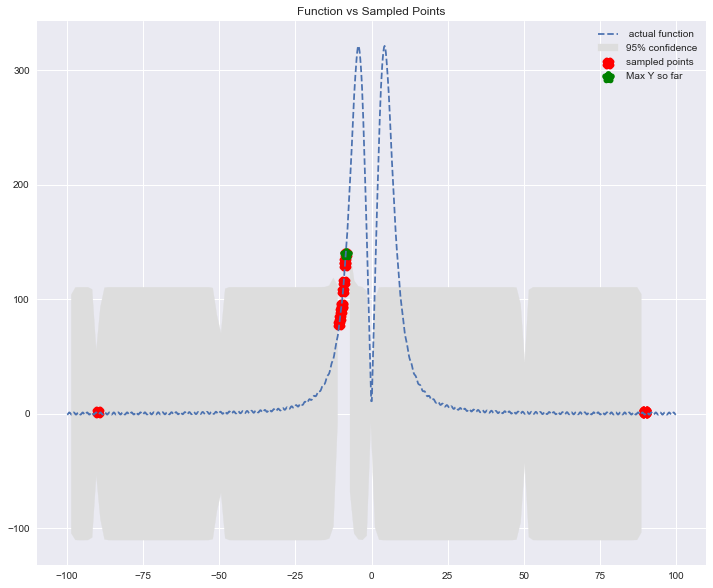

[-8.18791946] best_x
[-8.18791946] improv x
Point on x-axis just sampled =[-8.18791946]


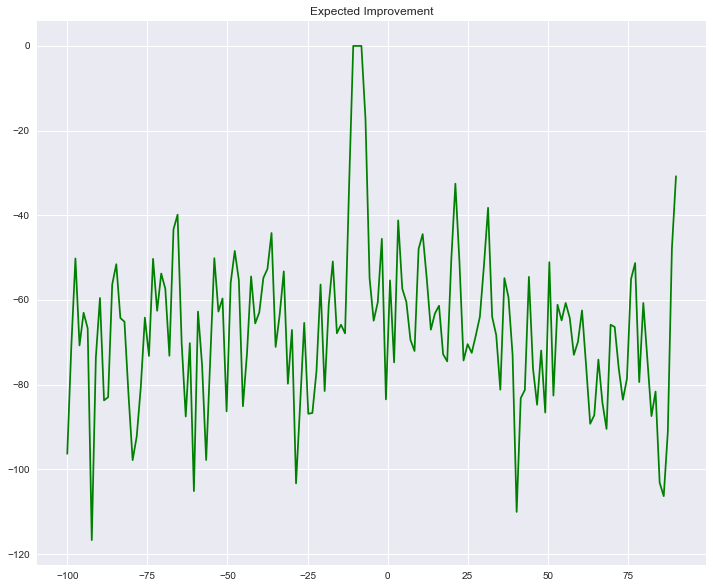

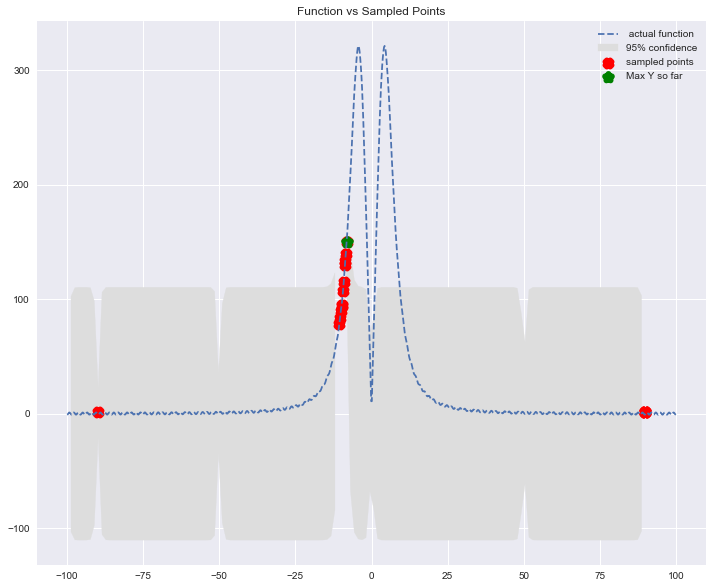

[-7.98742138] best_x
[-7.98742138] improv x
Point on x-axis just sampled =[-7.98742138]


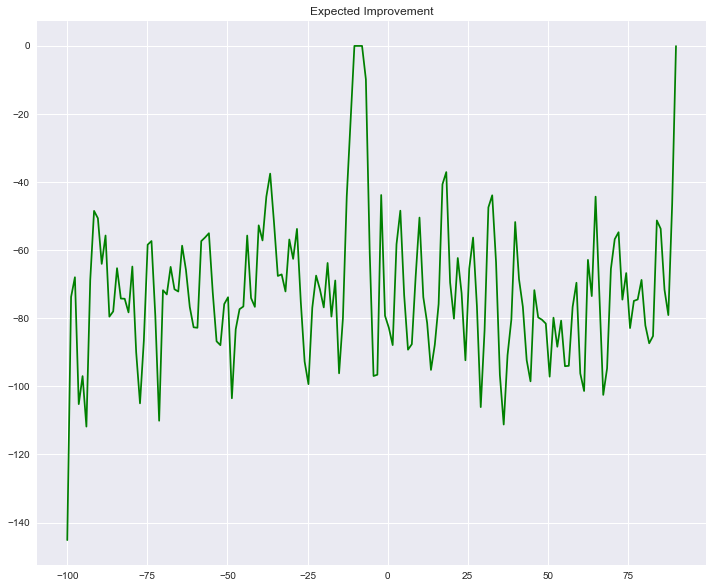

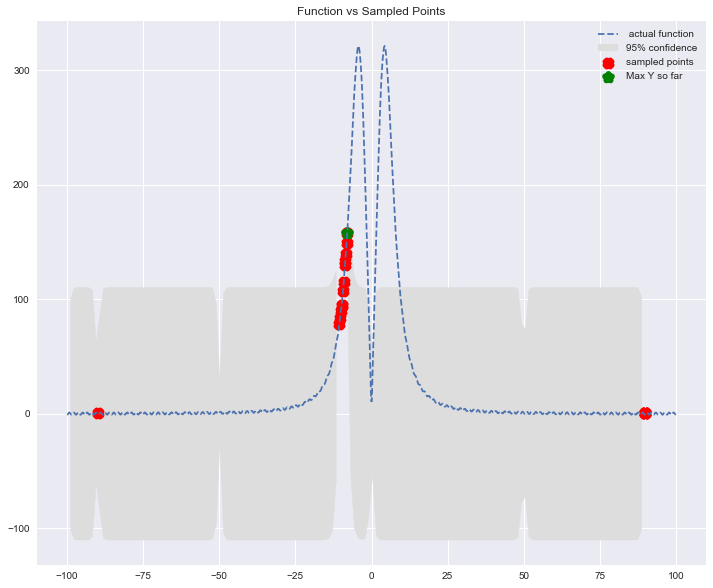

[-7.81065089] best_x
[-7.81065089] improv x
Point on x-axis just sampled =[-7.81065089]


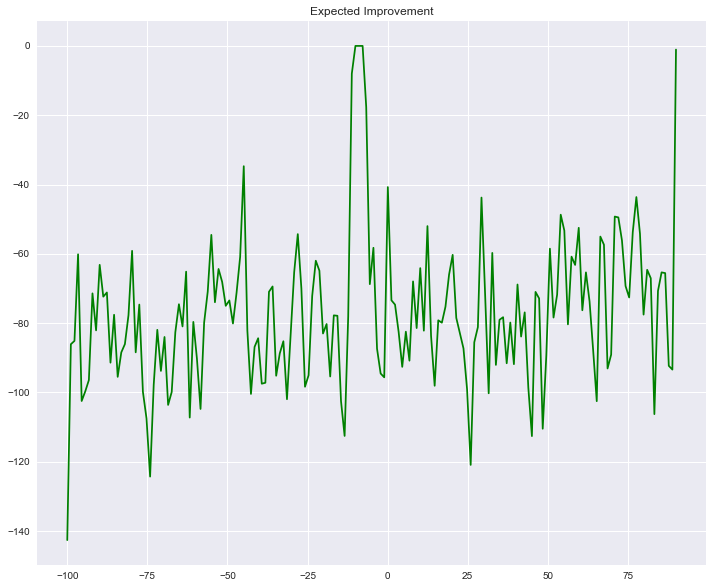

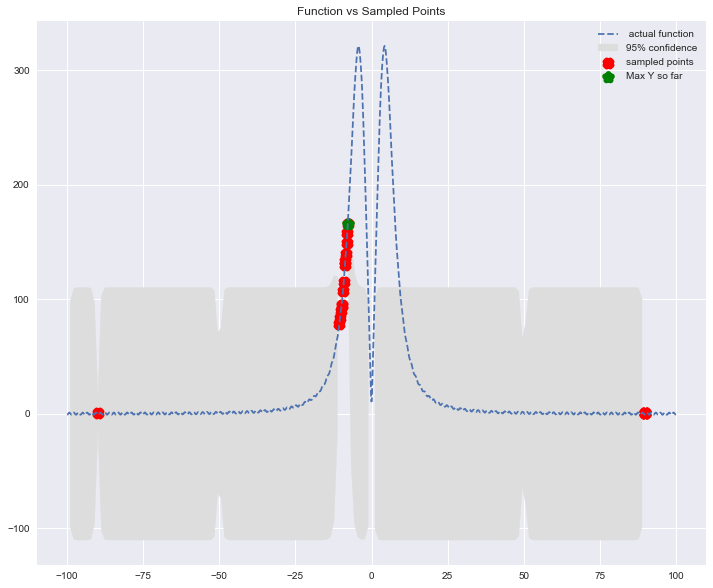

[-7.81065089] best_x
[-8.7150838] improv x
Point on x-axis just sampled =[-8.7150838]


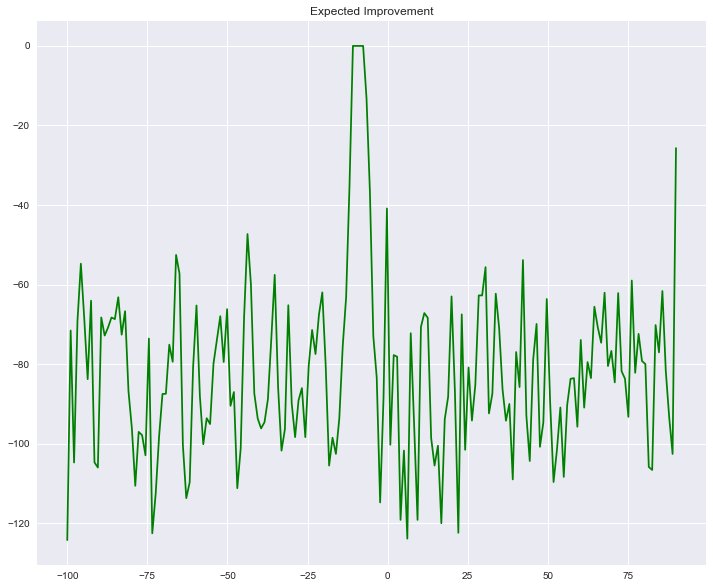

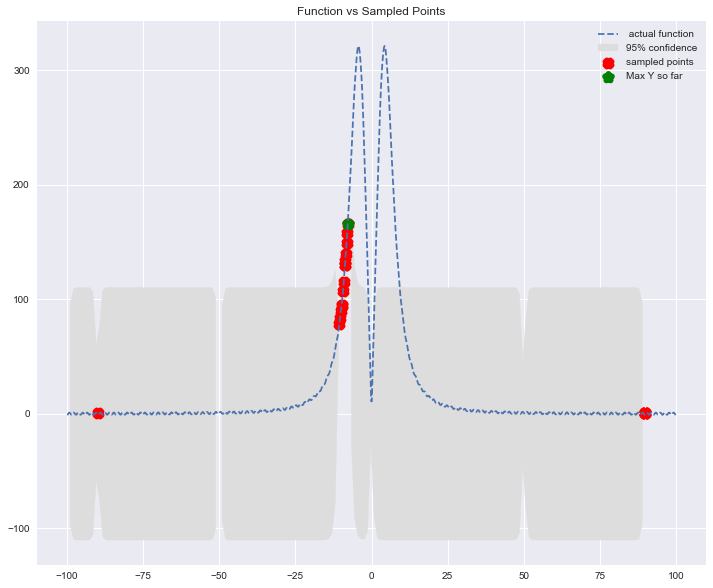

[-7.51322751] best_x
[-7.51322751] improv x
Point on x-axis just sampled =[-7.51322751]


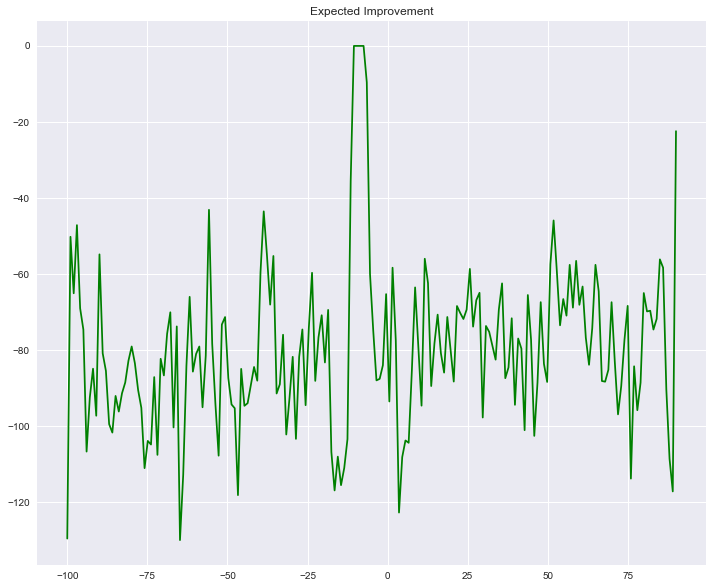

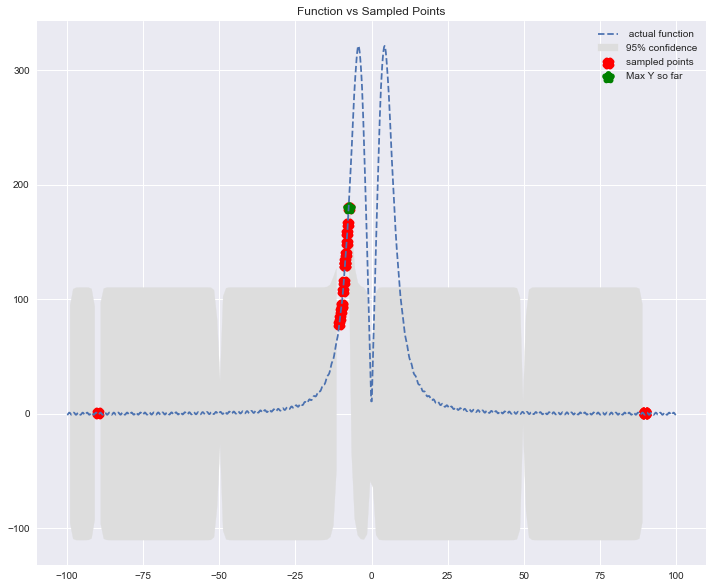

In [1331]:
# Used for Expected Improvement 

for i in range(samples):
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen)
    
    
        # Expectd Improvement
    plt.figure(figsize=(12,10))
    plt.title('Expected Improvement')
    plt.plot(domain,improvements,label='Expected improvements',color='green')
    
    
    
     # 95% confidence bars
    plt.figure(figsize=(12,10))
    plt.title("Function vs Sampled Points")
    plt.gca().fill_between( domain.flat, mus-2*np.sqrt(sampled_var),
                           mus+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
    
    
    train_y_x_axis = np.array(np.linspace(-100,100,1000))
    train_y_numbers_ = [train_y_func(i) for i  in train_y_x_axis]
    
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    
    print(f"Point on x-axis just sampled ={x_sampled_points[-1]}")
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Max Y so far',linewidths=6, color = 'green')

    
    mus = np.array(mus)
    domain = np.array(domain)

    plt.legend()
#     plt.ylim(-100,100)

    
    plt.show();


    
    # pause so we can see the graph
    #time.sleep(3);


# Objective Function

In [1172]:
# MSE
def mean_squarred_error(actual, predicted, negative = True):
    """MSE of actual and predicted value.
    Negative turn the MSE negative to allow for maximization instead of minimization"""
    if negative == True:
        return -np.linalg.norm(actual - predicted)/np.sqrt(len(actual))
    else:
        return np.linalg.norm(actual - predicted)/np.sqrt(len(actual))

In [1104]:
y = np.array([1,2]).reshape(-1,1)

In [1105]:
y_hat= np.array([2,1]).reshape(-1,1)

In [1106]:
mean_squarred_error(y,y_hat)

1.0

# Toy data set to optimize
- Wine ratings
- Use elastic net (find best hyperparamter)

In [1107]:
! curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10782  100 10782    0     0  63083      0 --:--:-- --:--:-- --:--:-- 81681


In [1110]:
cols = ['Alcohol','Malic acid','Ash','Alcalinity of ash  ','Magnesium','Total phenols','Flavanoids',
        'Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280','Proline    ']

In [1112]:
wine_df = pd.read_csv("wine.data",names=cols)

In [1115]:
wine_df .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 1 to 3
Data columns (total 13 columns):
Alcohol                 178 non-null float64
Malic acid              178 non-null float64
Ash                     178 non-null float64
Alcalinity of ash       178 non-null float64
Magnesium               178 non-null int64
Total phenols           178 non-null float64
Flavanoids              178 non-null float64
Nonflavanoid phenols    178 non-null float64
Proanthocyanins         178 non-null float64
Color intensity         178 non-null float64
Hue                     178 non-null float64
OD280                   178 non-null float64
Proline                 178 non-null int64
dtypes: float64(11), int64(2)
memory usage: 19.5 KB


In [1116]:
wine_df.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [1117]:
wine_df.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### Train test split to predict alcohol content

In [1167]:
X_train, X_test, y_train, y_test = train_test_split(wine_df.iloc[:,1:],wine_df.iloc[:,0], test_size=.2)

## Elastic Net Model
- Find the best L1 ratio
- Predicting the alcohol content

In [1181]:
def hyperparam_choice_function(hyperparameter_value, X_train_in=X_train, 
                               X_test_in = X_test, y_train_in = y_train, y_test_in = y_test,
                               model = ElasticNet):
    """Returns the negative MSE of the input hyperparameter for the given  hyperparameter.
    Used with GLMnet search over .
    Relies on a global name scope to bring in the data"""
    m = model(l1_ratio = hyperparameter_value)
    m.fit(X_train_in, y_train_in)
    pred = m.predict(X_test_in)
    n_mse = mean_squarred_error(y_test_in, pred)
    return n_mse
    

In [1429]:
ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1430]:
hyper_param_range = np.linspace(0,1,500)
train_x_hyp = np.array(np.random.choice(hyper_param_range,1)).reshape(-1,1)
train_y_hyp = np.array([hyperparam_choice_function(i) for i in train_x_hyp]).reshape(-1,1)
y_var_hyp = 5

In [1319]:
train_x_hyp

array([[ 0.16432866]])

In [1320]:
train_y_hyp

array([[-0.55525879]])

In [1427]:

samples = 10
gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                               squarred_kernel, y_var_hyp, testing_domain = range(0,2), n=samples )

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


STEP NUMBER = 0


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


Point on x-axis just sampled =[1]


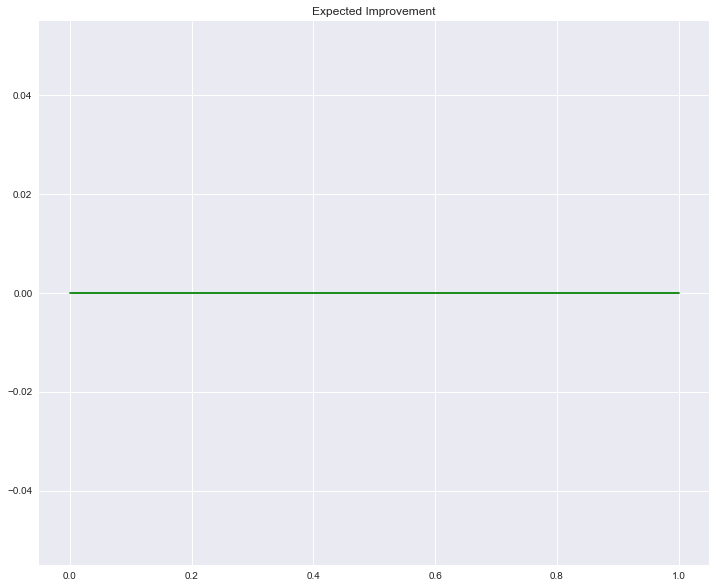

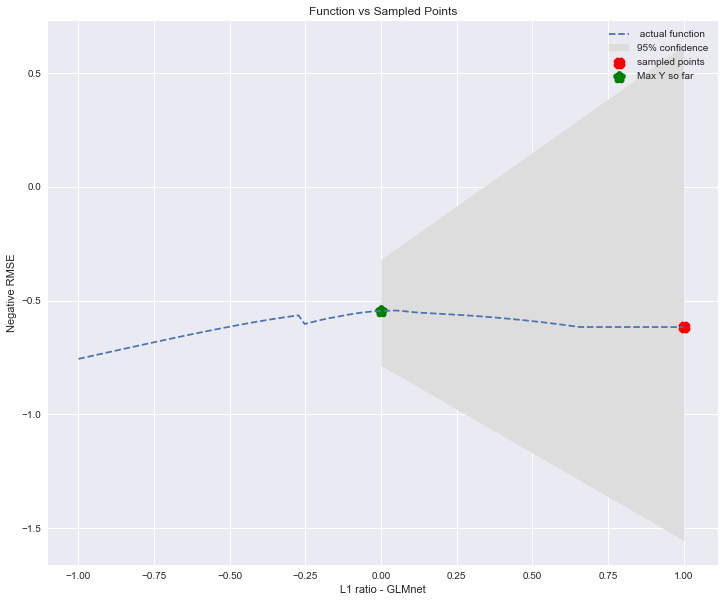

STEP NUMBER = 1
Best x (Bayesian OPtimization) = 0, Best y = -0.5451045527465782
Point on x-axis just sampled =[ 0.1001001]


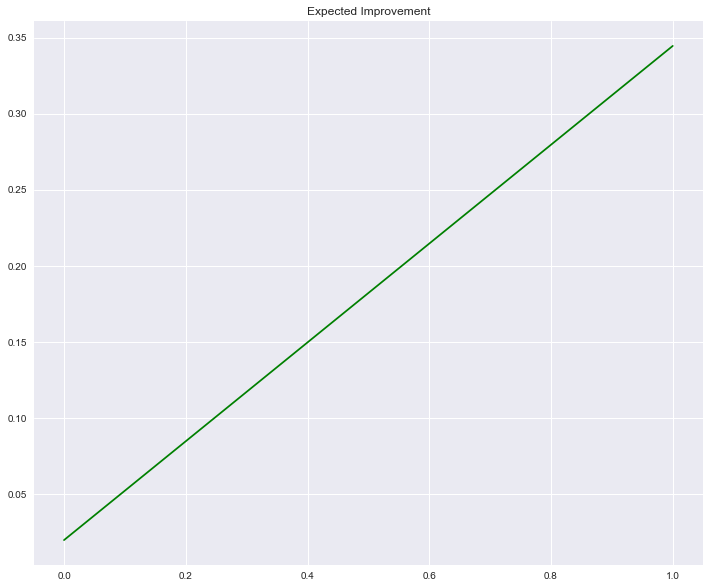

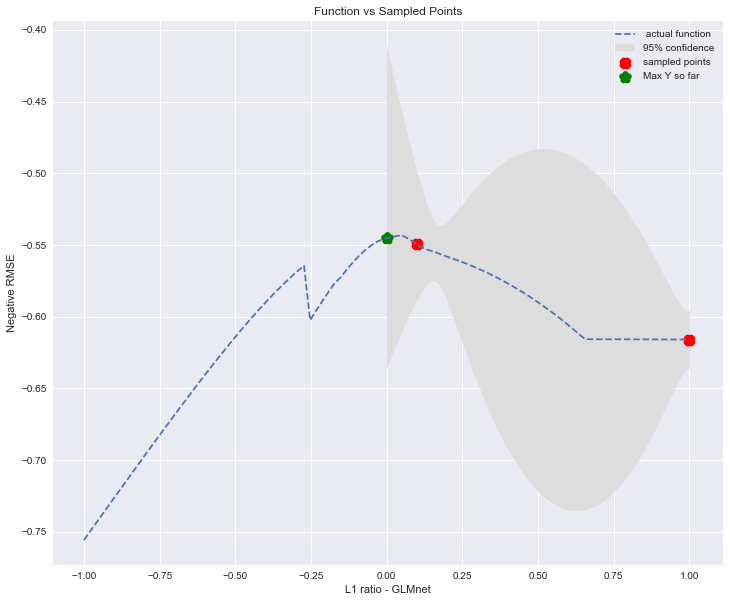

STEP NUMBER = 2
Best x (Bayesian OPtimization) = [ 0.04004004], Best y = -0.5433909846314733
Point on x-axis just sampled =[ 0.04004004]


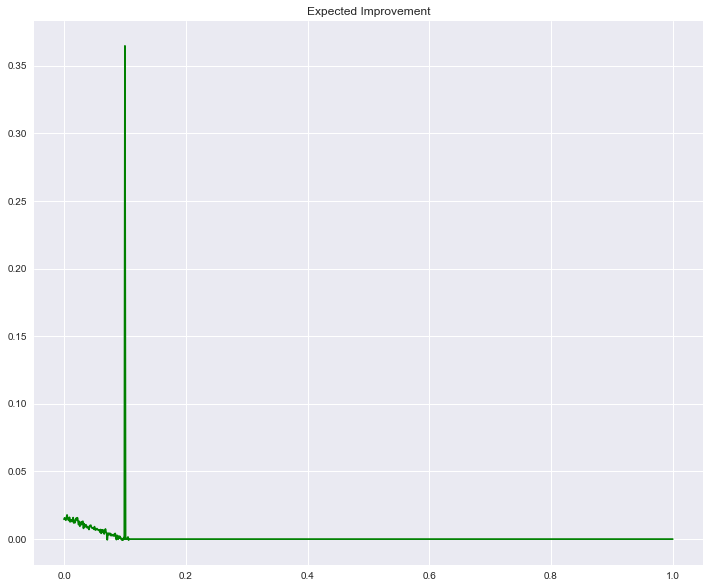

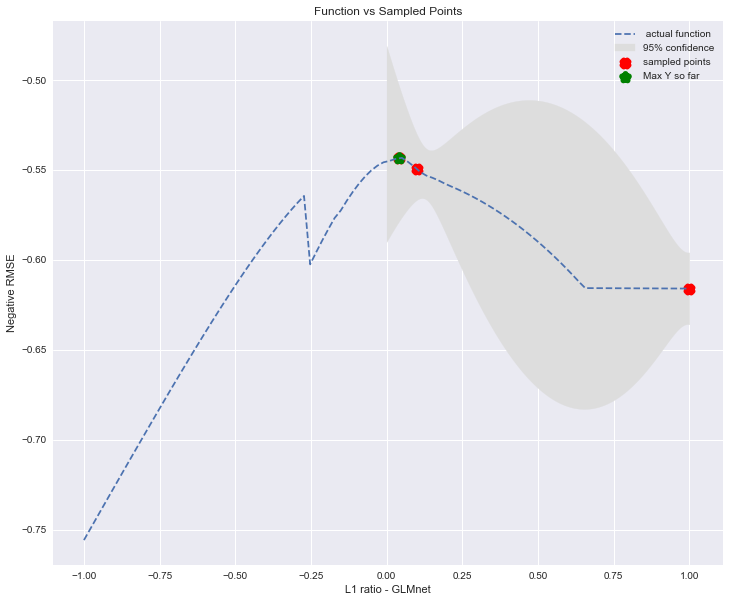

STEP NUMBER = 3
Best x (Bayesian OPtimization) = [ 0.04004004], Best y = -0.5433909846314733
Point on x-axis just sampled =[ 0.004004]


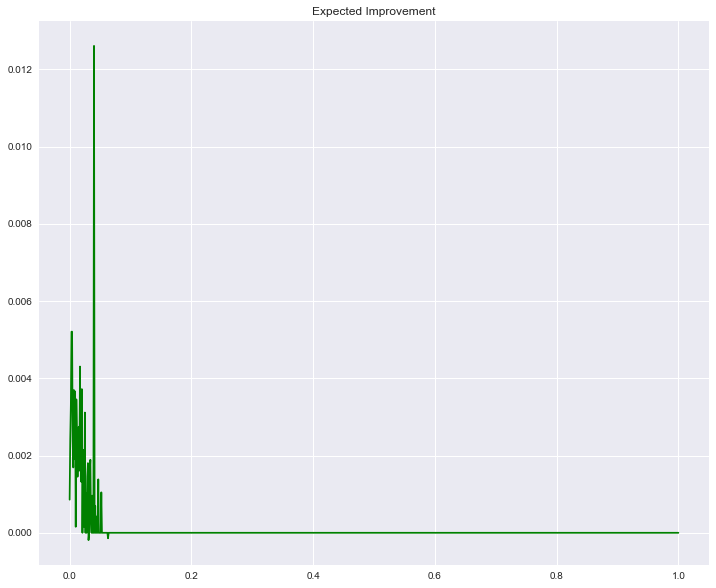

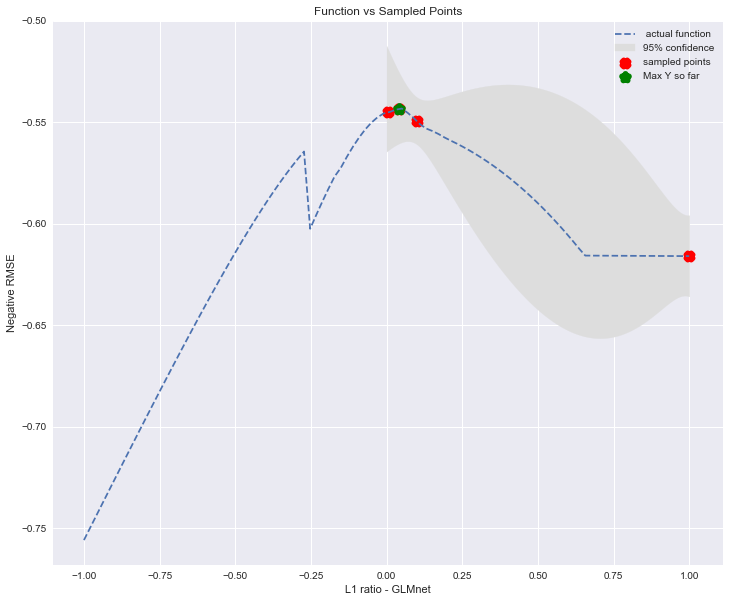

STEP NUMBER = 4


KeyboardInterrupt: 

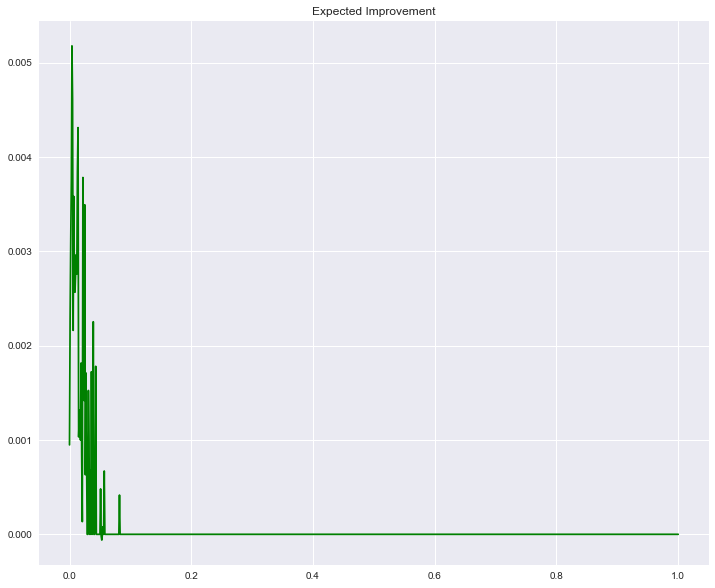

In [1428]:
# Used for Expected Improvement 
# For the real function, plot the values
train_y_x_axis = np.array(np.linspace(-1,1,100))
train_y_numbers_ = [hyperparam_choice_function(i) for i  in train_y_x_axis]
    
for i in range(samples):
    print('STEP NUMBER =',i)
    
    # Expectd Improvement
    plt.figure(figsize=(12,10))
    plt.title('Expected Improvement')
    plt.plot(domain,improvements,label='Expected improvements',color='green')
    
    
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
     # 95% confidence bars
    plt.figure(figsize=(12,10))
    plt.title("Function vs Sampled Points")
    plt.gca().fill_between( domain.flat, mus-2*np.sqrt(sampled_var),
                           mus+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
    
    
    
    
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    
    print(f"Point on x-axis just sampled ={x_sampled_points[-1]}")
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Max Y so far',linewidths=6, color = 'green')
    plt.ylabel('Negative RMSE')
    plt.xlabel('L1 ratio - GLMnet')

    
    mus = np.array(mus)
    domain = np.array(domain)

    plt.legend()
#     plt.ylim(-100,100)

    
    plt.show();


    
    # pause so we can see the graph
    #time.sleep(3);


# Compare performance of finding the l1 ratio to random search and grid search

In [1384]:
def grid_search(range_, h_choice = hyperparam_choice_function):
    """A generator that methodically searches through the input range and return the x val, and the negative RMSE
   Range should be np.linspace steps = 1k This is the number of steps in the bayesian optimization algo"""
    if len(range_)!=1_000:
        return "Incorrect range"
    else:
        for x in range_:
            yield (x,h_choice(x))

In [1436]:
# gridsearch gen
grid_gen = grid_search(np.linspace(0,1,1_000))

In [1437]:
samples = 10
gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                               squarred_kernel, y_var_hyp, testing_domain = range(0,2), n=samples )
# sample from generator
x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
    

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


STEP NUMBER = 1
Bayesian Optimization just samples point = [ 0.002002]
Best x (Bayesian OPtimization) = [ 0.002002], Best y = -0.5450374994316208
Grid search just sampled point = 0.0
Best X (Grid Search) = 0.0, Best y = -0.5451045527465782


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


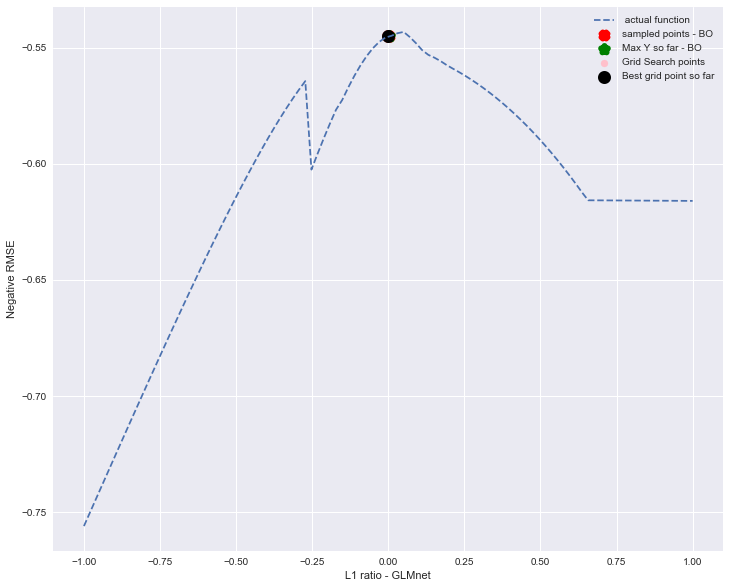

STEP NUMBER = 2
Bayesian Optimization just samples point = [ 0.00500501]
Best x (Bayesian OPtimization) = [ 0.002002], Best y = -0.5450374994316208
Grid search just sampled point = 0.001001001001001001
Best X (Grid Search) = 0.001001001001001001, Best y = -0.5450642441599128


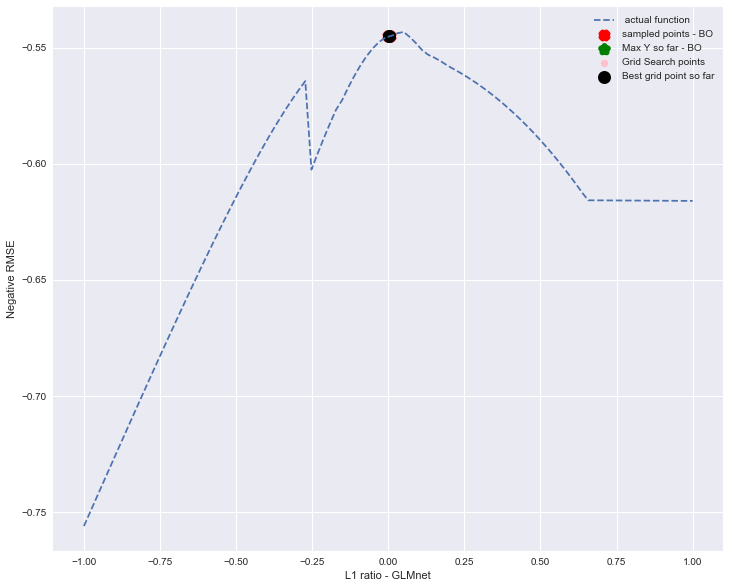

STEP NUMBER = 3
Bayesian Optimization just samples point = [ 0.]
Best x (Bayesian OPtimization) = [ 0.002002], Best y = -0.5450374994316208
Grid search just sampled point = 0.002002002002002002
Best X (Grid Search) = 0.002002002002002002, Best y = -0.5450374994316208


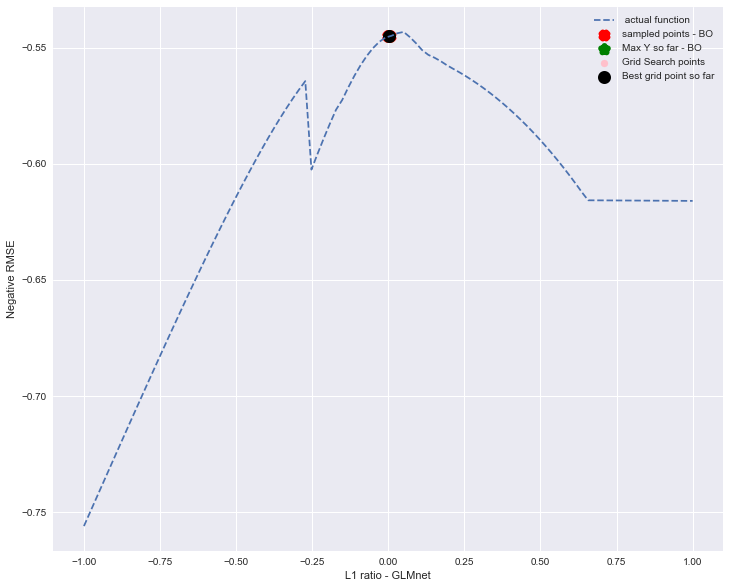

STEP NUMBER = 4
Bayesian Optimization just samples point = [ 0.002002]
Best x (Bayesian OPtimization) = [ 0.002002], Best y = -0.5450374994316208
Grid search just sampled point = 0.003003003003003003
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531


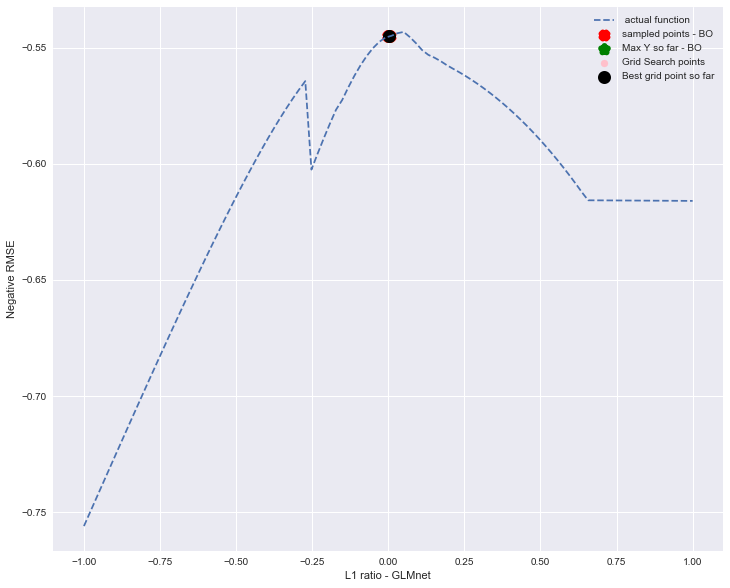

STEP NUMBER = 5
Bayesian Optimization just samples point = [ 0.00800801]
Best x (Bayesian OPtimization) = [ 0.002002], Best y = -0.5450374994316208
Grid search just sampled point = 0.004004004004004004
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531


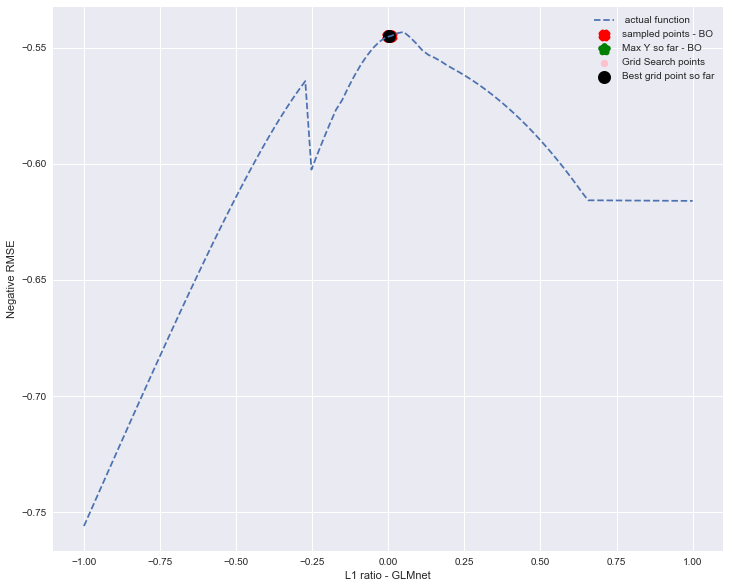

STEP NUMBER = 6
Bayesian Optimization just samples point = [ 0.04304304]
Best x (Bayesian OPtimization) = [ 0.04304304], Best y = -0.5432785940926873
Grid search just sampled point = 0.005005005005005005
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531


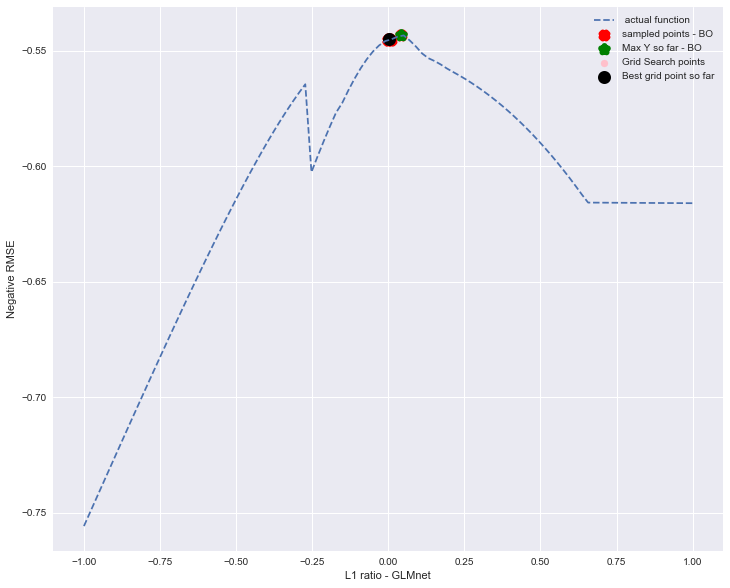

STEP NUMBER = 7
Bayesian Optimization just samples point = [ 0.01401401]
Best x (Bayesian OPtimization) = [ 0.04304304], Best y = -0.5432785940926873
Grid search just sampled point = 0.006006006006006006
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531


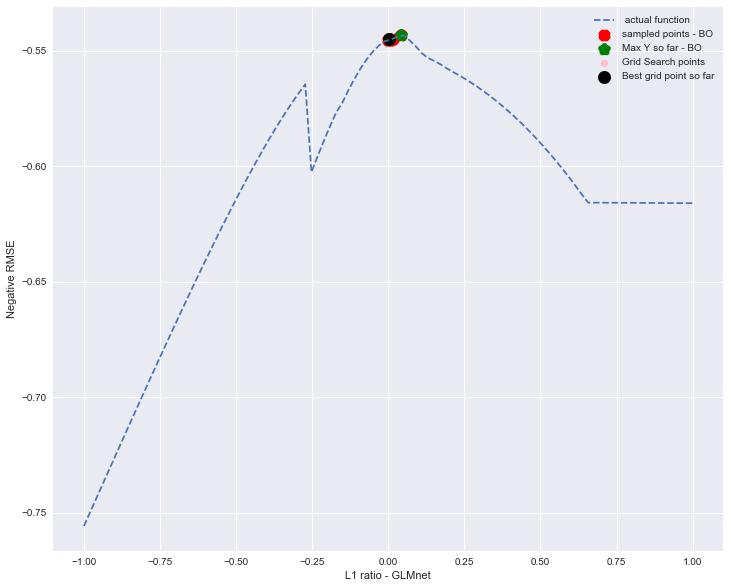

STEP NUMBER = 8
Bayesian Optimization just samples point = [ 0.001001]
Best x (Bayesian OPtimization) = [ 0.04304304], Best y = -0.5432785940926873
Grid search just sampled point = 0.007007007007007007
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531


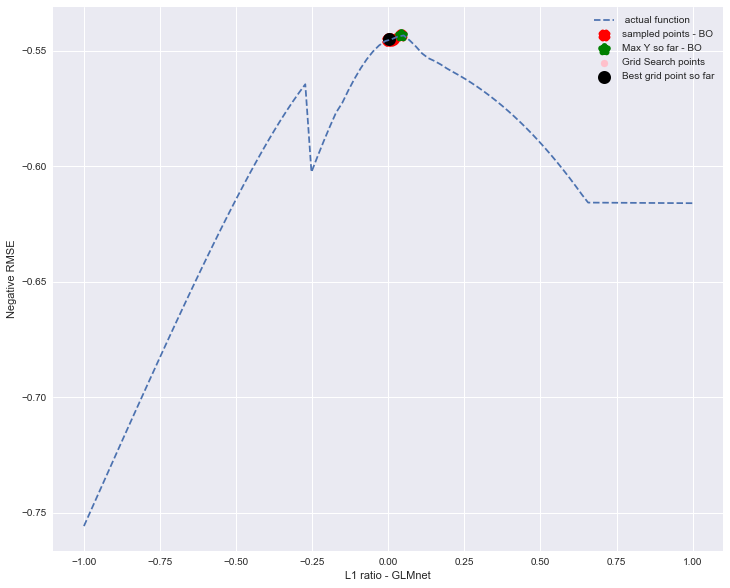

STEP NUMBER = 9
Bayesian Optimization just samples point = [ 0.]
Best x (Bayesian OPtimization) = [ 0.04304304], Best y = -0.5432785940926873
Grid search just sampled point = 0.008008008008008008
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531


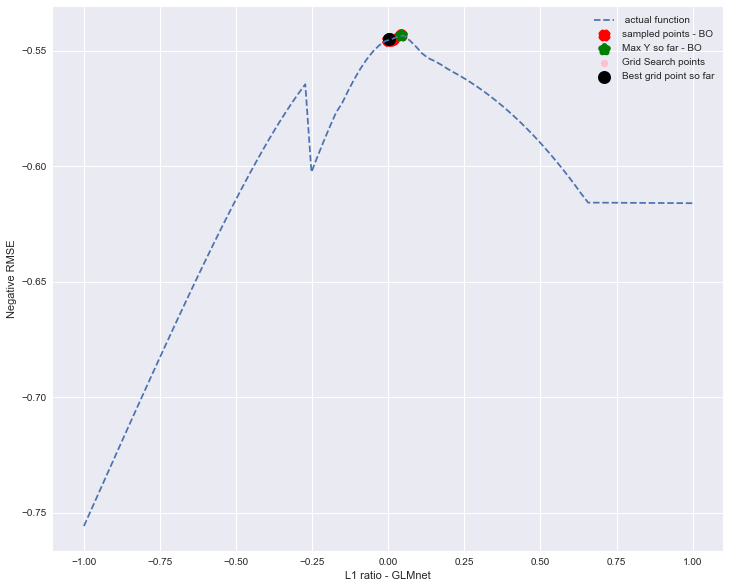

STEP NUMBER = 10


StopIteration: 

In [1438]:
# Plot Bayesian Optimization vs grid search
# For the real function, plot the values
train_y_x_axis = np.array(np.linspace(-1,1,100))
train_y_numbers_ = [hyperparam_choice_function(i) for i  in train_y_x_axis]
# keep track of best points
best_y_grid = -9999999
best_x_grid = None
sampled_x_grid = []
sampled_y_grid = []

for i in range(samples):
    print('STEP NUMBER =',i+1)
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
    # sample from gridsearch
    x_grid, y_grid = next(grid_gen)
    # keep track of best gridsearch parameters
    if y_grid > best_y_grid:
        best_y_grid = y_grid
        best_x_grid = x_grid
    # append these points to the list we are keeping track of for grid search 
    sampled_x_grid.append(x_grid)
    sampled_y_grid.append(y_grid)
    #
    print(f"Grid search just sampled point = {x_grid}")
    print(f"Best X (Grid Search) = {best_x_grid}, Best y = {best_y_grid}")
    
    #plot actual function
    plt.figure(figsize=(12,10))
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    plt.ylabel('Negative RMSE')
    plt.xlabel('L1 ratio - GLMnet')
    
    # Results so far from bayesian optimization
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points - BO',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Max Y so far - BO',linewidths=6, color = 'green') # best point
    
    # Results from grid search
    plt.scatter(sampled_x_grid,sampled_y_grid, marker = 'o', label='Grid Search points', color='pink')
    plt.scatter(best_x_grid,best_y_grid , label='Best grid point so far', linewidths=6, color = 'Black')
    
    plt.legend()
    plt.show();